In [1]:
import os, sys
import numpy as np
import json
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

## Preliminary

In [2]:
EPOCHS = 20
k = 5000 # number of samples used to calculate loss

In [3]:
torch.manual_seed(12345)
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
na_list = ['A', 'C', 'G', 'T'] #nucleic acids
aa_list = ['R', 'L', 'S', 'A', 'G', 'P', 'T', 'V', 'N', 'D', 'C', 'Q', 'E', 'H', 'I', 'K', 'M', 'F', 'W', 'Y'] #amino acids
NNK_freq = [0.09375]*3 + [0.0625]*5 + [0.03125]*13 #freq of 21 NNK codons including the stop codon
sum_20 = 0.0625*5 + 0.09375*3 + 0.03125*12 #sum of freq without the stop codon
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*12 #normalize freq for 20 codons
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11 + \
        [1- sum([0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11)] 
        #adjust sum to 1 due to numerical issue
aa_dict = dict(zip(aa_list, pvals))

## Dataset & Sampling

In [4]:
def construct_dataset():
    with open(aptamer_dataset_file, 'r') as f:
        aptamer_data = json.load(f)
    ds = []
    for aptamer in aptamer_data:
        peptides = aptamer_data[aptamer]
        if aptamer == "CTTTGTAATTGGTTCTGAGTTCCGTTGTGGGAGGAACATG": #took out aptamer control
            continue
        for peptide, _ in peptides:
            peptide = peptide.replace("_", "") #removed stop codons
            if "RRRRRR" in peptide: #took out peptide control
                continue
            if len(aptamer) == 40 and len(peptide) == 8: #making sure right length
                ds.append((aptamer, peptide))
    ds = list(set(ds)) #removed duplicates
    return ds

# Sample x from P_X (assume apatamers follow uniform)
def get_x():
    x_idx = np.random.randint(0, 4, 40)
    x = ""
    for i in x_idx:
        x += na_list[i]
    return x

# Sample y from P_y (assume peptides follow NNK)
def get_y():
    y_idx = np.random.choice(20, 7, p=pvals)
    y = "M"
    for i in y_idx:
        y += aa_list[i]
    return y

# S'(train/test) contains S_train/S_test with double the size of S_train/S_test
def get_S_prime(kind="train"):
    if kind == "train":
        dset = S_train
    else:
        dset = S_test
    k = len(dset)
    S_prime_dict = dict.fromkeys(dset, 0) #indicator 0 means in S
    for _ in range(k):
        pair = (get_x(), get_y())
        S_prime_dict[pair] = 1 #indicator 1 means not in S
    S_prime = [[k,int(v)] for k,v in S_prime_dict.items()] 
    np.random.shuffle(S_prime)
    return S_prime

# S new contains unseen new examples
def get_S_new(k):
    S_new = []
    for i in range(k):
        pair = (get_x(), get_y())
        S_new.append(pair)
    np.random.shuffle(S_new)
    return S_new
    
# Returns pmf of an aptamer
def get_x_pmf():
    return 0.25**40

# Returns pmf of a peptide
def get_y_pmf(y):
    pmf = 1
    for char in y[1:]: #skips first char "M"
        pmf *= aa_dict[char]
    return pmf    

In [5]:
aptamer_dataset_file = "../data/aptamer_dataset.json"
S = construct_dataset()
n = len(S)
m = int(0.8*n) #length of S_train
S_train = S[:m]
S_test = S[m:]
S_prime_train = get_S_prime("train") #use for sgd 
S_prime_test = get_S_prime("test") #use for sgd 
S_new = get_S_new(10*n) #use for eval
train_ds = np.hstack((S_train, S_prime_train[:len(S_prime_train)//2]))

## NN Model

In [6]:
class SimpleConvNet(nn.Module):
    def __init__(self):
        super(SimpleConvNet, self).__init__()
        self.cnn_apt_1 = nn.Conv2d(1, 120, (4,4)) #similar to 4-gram
        self.cnn_pep_1 = nn.Conv2d(1, 50, (4,20))
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(4690, 1)
        
    def forward(self, apt, pep):
        apt = self.cnn_apt_1(apt)
        apt = self.relu(apt)
        pep = self.cnn_pep_1(pep)
        pep = self.relu(pep)
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.zeros_(m.bias.data)
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='sigmoid')
        nn.init.zeros_(m.bias.data)

In [7]:
class MoreComplexNet(nn.Module):
    def __init__(self):
        super(MoreComplexNet, self).__init__()
        self.cnn_apt_1 = nn.Conv2d(1, 500, 1) #similar to 5-gram
        self.cnn_apt_2 = nn.Conv2d(500, 1000, 1)
        self.cnn_apt_3 = nn.Conv2d(1000, 500, 2)
        self.cnn_apt_4 = nn.Conv2d(500, 100, 2)
        self.cnn_apt_5 = nn.Conv2d(100, 10, 2)
        
        self.cnn_pep_1 = nn.Conv2d(1, 250, 1)
        self.cnn_pep_2 = nn.Conv2d(250, 500, 1)
        self.cnn_pep_3 = nn.Conv2d(500, 250, 3)
        self.cnn_pep_4 = nn.Conv2d(250, 100, 2)
        self.cnn_pep_5 = nn.Conv2d(100, 10, 2)
        
        self.relu = nn.ReLU()
        
        self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.relu, self.cnn_apt_2, self.relu, self.cnn_apt_3, self.relu, self.cnn_apt_4, self.relu, self.cnn_apt_5)
        self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.relu, self.cnn_pep_2, self.relu, self.cnn_pep_3, self.relu, self.cnn_pep_4, self.relu, self.cnn_pep_5)
        
        
        self.fc1 = nn.Linear(1010, 1)
    
    def forward(self, apt, pep):
        apt = self.cnn_apt(apt)
        apt = self.relu(apt)
        pep = self.cnn_pep(pep)
        pep = self.relu(pep)
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

## Helper methods

In [8]:
## Takes a peptide and aptamer sequence and converts to one-hot matrix
def one_hot(sequence, seq_type='peptide'):
    if seq_type == 'peptide':
        letters = aa_list
    else:
        letters = na_list
    one_hot = np.zeros((len(sequence), len(letters)))
    for i in range(len(sequence)):
        char = sequence[i]
        for _ in range(len(letters)):
            idx = letters.index(char)
            one_hot[i][idx] = 1
    return one_hot

# Convert a pair to one-hot tensor
def convert(apt, pep): 
    apt = one_hot(apt, seq_type='aptamer') #(40, 4)
    pep = one_hot(pep, seq_type='peptide') #(8, 20)
    apt = torch.FloatTensor(np.reshape(apt, (1, 1, apt.shape[0], apt.shape[1]))).cuda() #(1, 1, 40, 4)
    pep = torch.FloatTensor(np.reshape(pep, (1, 1, pep.shape[0], pep.shape[1]))).cuda() #(1, 1, 8, 20)
    return apt, pep

# Getting the output of the model for a pair (aptamer, peptide)
def update(x, y):
    x.requires_grad=True
    y.requires_grad=True
    x = x.cuda()
    y = y.cuda()
    out = model(x, y)
    return out

# Generates the samples used to calculate loss
def loss_samples(k, ds='train'): # S_train/S_test
    if ds == 'train':
        dset = S_train
    else:
        dset = S_test
    pairs = []
    for (apt, pep) in dset[:k]:
        x, y = convert(apt, pep)
        pairs.append((x, y))
    return pairs

# Generates the samples used to calculate loss from S_prime_train/S_prime_test
def prime_loss_samples(k, ds='train'): # S_prime_train/S_prime_test
    if ds == "train":
        dset = S_prime_train[len(S_prime_train)//2:]    
    else:
        dset = S_prime_test[len(S_prime_test)//2:]
    pairs = []
    for (apt, pep), ind in dset[:k]:
        pmf = get_y_pmf(pep)
        x, y = convert(apt, pep)
        pairs.append((x, y, ind, pmf))
    return pairs

# First term of the loss
def get_log_out(dataset='train'):
    outs = []
    if dataset == 'train':
        dset = train_loss_samples
    else:
        dset = test_loss_samples
    for (apt, pep) in dset:
        out = update(apt, pep)
        outs.append(torch.log(out).cpu().detach().numpy().flatten()[0])
    return np.average(outs)

# Second term of loss
def get_out_prime(ds="train"):
    outs = []
    if ds == "train":
        dset = prime_train_loss_samples
        leng = m
    else:
        dset = prime_test_loss_samples
        leng = n-m
    for (apt, pep, ind, pmf) in dset:
        x = apt.cuda()
        y = pep.cuda()
        out = model(x, y)
        if ind == 0:
            factor = (2*leng*get_x_pmf()*pmf)/(1+leng*get_x_pmf()*pmf)
        else:
            factor = 2
        out_is = out.cpu().detach().numpy().flatten()[0] * factor
        outs.append(out_is)
    return np.average(outs)

## Plotting functions

def plot_loss(train_loss, test_loss, i, j, lamb, gamma):
    plt.plot(train_loss, 'b', label='Train loss')
    plt.plot(test_loss, 'y', label='Test loss')
    plt.ylabel("Loss")
    plt.xlabel("Number of iterations")
    plt.title('Loss after ' +  str(i) + " iterations, " + str(j) + " epochs, " + 'lambda =%.5f' % lamb  + ' gamma =%.5f' % gamma)
    plt.legend()
    plt.show()

def plot_recall(train_recall, test_recall, i, j, lamb, gamma):
    plt.plot(train_recall, 'b', label='Train recall')
    plt.plot(test_recall, 'y', label='Test recall')
    plt.ylabel("Recall (%)")
    plt.xlabel("Number of iterations")
    plt.title('Recall after ' + str(i) + " iterations, " + str(j) + " epochs, " + 'lambda =%.5f' % lamb  + ' gamma =%.5f' % gamma)
    plt.legend()
    plt.show()
    
def plot_cdf(train_cdf, test_cdf, i, j, lamb, gamma):
    plt.plot(train_cdf, 'b', label='Train CDF')
    plt.plot(test_cdf, 'y', label='Test CDF')
    plt.ylabel("CDF")
    plt.xlabel("Most recent 10,000 samples")
    plt.title('CDF after ' + str(i) + " iterations, " + str(j) + " epochs, " + 'lambda =%.5f' % lamb  + ' gamma =%.5f' % gamma)
    plt.legend()
    plt.show()

In [9]:
train_loss_samples = loss_samples(k, 'train')
test_loss_samples = loss_samples(k, 'test')
prime_train_loss_samples = prime_loss_samples(k, 'train')
prime_test_loss_samples = prime_loss_samples(k, 'test')

## SGD

In [15]:
def sgd(lamb=1e28, #hyperparam
        gamma=1e-3, #step size
        save_checkpoints=False): #save checkpoints
    
    optim = SGD(model.parameters(), lr=gamma)
    for j in range(EPOCHS):
        
        train_losses = []
        train_recalls = []
        train_recall_outputs = [] 

        test_losses = []
        test_recalls = []
        test_recall_outputs = []

        new_outputs = []

        train_correct = 0
        test_correct = 0
        
        for i, (aptamer, peptide, (apt_prime, pep_prime), indicator) in enumerate(tqdm.tqdm(train_ds)):
            if i == 0:
                continue
            model.train()
            optim.zero_grad() 
            x, y = convert(aptamer, peptide) #sample x,y from S_train
            out = update(x, y) #get S_train output/score
            log_out = torch.log(out) 
            
            train_score = out.cpu().detach().numpy().flatten()[0] 
            if train_score > 0.6:
                train_correct += 1 
            train_recall_outputs.append(train_score) 

            optim.zero_grad() 
            y_pmf = get_y_pmf(pep_prime)
            x_prime, y_prime = convert(apt_prime, pep_prime) #sample x', y' from S_prime_train
            out_prime = update(x_prime, y_prime) #get score from S_prime_train
            if indicator == 0:
                factor = (2*m*get_x_pmf()*y_pmf)/(1+m*get_x_pmf()*y_pmf)
            else:
                factor = 2
            out_prime = out_prime*factor #adjust for IS
            print("Obj first part: ", out_prime.cpu().detach().numpy().flatten()[0]*lamb*indicator)
            print("Obj second part: ", log_out.cpu().detach().numpy().flatten()[0])
            # Retain graph retains the graph for further operations
            (lamb*indicator*out_prime - log_out).backward(retain_graph=True) 
            optim.step()

            with torch.no_grad():
                model.eval()
            
            x_test, y_test = convert(S_test[i%(n-m)][0], S_test[i%(n-m)][1]) #sample x,y from test set
            test_score = model(x_test, y_test).cpu().detach().numpy().flatten()[0]
            test_recall_outputs.append(test_score) 
            if test_score > 0.6:
                test_correct += 1 

            #generate 10 unseen examples from S_new as compared 1 example from S_train/S_test for cdfs
            for x, y in S_new[10*i:10*(i+1)]:
                x_new, y_new = convert(x, y) #generate unseen x'' and y'' from S_new
                new_score = model(x_new, y_new).cpu().detach().numpy().flatten()[0] #get unknown score
                new_outputs.append(new_score)

            if i % 100 == 0:
                train_loss = lamb*get_out_prime("train") - get_log_out('train') #training loss
                print("Train loss first part: ", lamb*get_out_prime("train"))
                print("Train loss second part: ", get_log_out('train'))
                test_loss = (m/(n-m))*lamb*get_out_prime("test") - get_log_out('test') #test loss
                print("Test loss first part: ", lamb*get_out_prime("test"))
                print("Test loss second part: ", get_log_out('test'))
                train_losses.append(train_loss)
                test_losses.append(test_loss)

                train_recall = 100*train_correct/i #training recall
                train_recalls.append(train_recall) 
                test_recall = 100*test_correct/i #test recall
                test_recalls.append(test_recall)
                if i > 1000:
                    train_score = np.asarray(new_outputs[-10000:] + train_recall_outputs[-1000:]) 
                    test_score = np.asarray(new_outputs[-10000:] + test_recall_outputs[-1000:])
                else:
                    train_score = np.asarray(new_outputs + train_recall_outputs) #combine train and unknown scores
                    test_score = np.asarray(new_outputs + test_recall_outputs) #combibne test and unknown scores
                train_cdf = np.cumsum(train_score)/np.sum(train_score) #train cdf
                test_cdf = np.cumsum(test_score)/np.sum(test_score) #test cdf


            if i % 500 == 0:
                plot_recall(train_recalls, test_recalls, i, j, lamb, gamma)
                plot_loss(train_losses, test_losses, i, j, lamb, gamma)
                plot_cdf(train_cdf, test_cdf, i, j, lamb, gamma)
                print("New score: ", np.average(new_outputs[-50:]))
                print("Train score: ", np.average(train_score[-50:]))
                print("Test score: ", np.average(test_score[-50:]))
        # Save after every epoch
        if save_checkpoints:
            torch.save({'epoch': j,'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, '../models/model_checkpoints/mle_model.pth')
            

## Hyperparameter tuning

In [16]:
# Hyperparameter search
gammas = [1e-3, 1e-2]
lambdas = [10, 5, 2]



  0%|          | 0/473047 [00:00<?, ?it/s]

Labmda: 10 Gamma: 0.001
('Obj first part: ', 10.054479837417603)
('Obj second part: ', -0.7105208)
('Obj first part: ', 10.045503377914429)
('Obj second part: ', -0.6949889)
('Obj first part: ', 9.865582585334778)
('Obj second part: ', -0.70078313)




  0%|          | 4/473047 [00:00<3:42:33, 35.42it/s]

  0%|          | 7/473047 [00:00<4:05:28, 32.12it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -0.71837837)
('Obj first part: ', 9.676278829574585)
('Obj second part: ', -0.7193904)
('Obj first part: ', 9.43494737148285)
('Obj second part: ', -0.7258544)
('Obj first part: ', 0.0)
('Obj second part: ', -0.72641635)
('Obj first part: ', 0.0)
('Obj second part: ', -0.72323996)
('Obj first part: ', 9.625979661941528)
('Obj second part: ', -0.7186603)




  0%|          | 10/473047 [00:00<4:22:12, 30.07it/s]

  0%|          | 13/473047 [00:00<4:33:10, 28.86it/s]

('Obj first part: ', 9.662039875984192)
('Obj second part: ', -0.7356536)
('Obj first part: ', 0.0)
('Obj second part: ', -0.7355859)
('Obj first part: ', 9.389182925224304)
('Obj second part: ', -0.75260985)
('Obj first part: ', 0.0)
('Obj second part: ', -0.73829466)
('Obj first part: ', 9.378103017807007)
('Obj second part: ', -0.76177084)
('Obj first part: ', 0.0)
('Obj second part: ', -0.76876014)




  0%|          | 16/473047 [00:00<4:42:56, 27.86it/s]

  0%|          | 19/473047 [00:00<4:47:55, 27.38it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -0.75802267)
('Obj first part: ', 0.0)
('Obj second part: ', -0.7412693)
('Obj first part: ', 9.377570152282715)
('Obj second part: ', -0.74571806)
('Obj first part: ', 9.251853227615356)
('Obj second part: ', -0.7696955)
('Obj first part: ', 9.290438294410706)
('Obj second part: ', -0.7972008)
('Obj first part: ', 9.024861454963684)
('Obj second part: ', -0.8011972)




  0%|          | 22/473047 [00:00<4:51:07, 27.08it/s]

  0%|          | 25/473047 [00:00<4:53:09, 26.89it/s]

('Obj first part: ', 8.863983154296875)
('Obj second part: ', -0.78024966)
('Obj first part: ', 0.0)
('Obj second part: ', -0.85086477)
('Obj first part: ', 0.0)
('Obj second part: ', -0.81007385)
('Obj first part: ', 8.761160373687744)
('Obj second part: ', -0.83473784)
('Obj first part: ', 8.604588508605957)
('Obj second part: ', -0.8484068)
('Obj first part: ', 0.0)
('Obj second part: ', -0.8581687)




  0%|          | 28/473047 [00:01<4:54:43, 26.75it/s]

  0%|          | 31/473047 [00:01<4:55:01, 26.72it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -0.8479586)
('Obj first part: ', 0.0)
('Obj second part: ', -0.8571474)
('Obj first part: ', 8.344258069992065)
('Obj second part: ', -0.85655975)
('Obj first part: ', 8.12105417251587)
('Obj second part: ', -0.905496)
('Obj first part: ', 7.708882093429565)
('Obj second part: ', -0.939525)
('Obj first part: ', 7.669330835342407)
('Obj second part: ', -0.95094883)




  0%|          | 34/473047 [00:01<4:55:56, 26.64it/s]

  0%|          | 37/473047 [00:01<4:58:25, 26.42it/s]

('Obj first part: ', 7.155939936637878)
('Obj second part: ', -1.0034387)
('Obj first part: ', 6.706050634384155)
('Obj second part: ', -1.0391457)
('Obj first part: ', 0.0)
('Obj second part: ', -1.1185737)
('Obj first part: ', 6.566362977027893)
('Obj second part: ', -1.1324456)
('Obj first part: ', 0.0)
('Obj second part: ', -1.151177)
('Obj first part: ', 0.0)
('Obj second part: ', -1.1811103)




  0%|          | 40/473047 [00:01<5:04:26, 25.89it/s]

  0%|          | 43/473047 [00:01<5:08:59, 25.51it/s]

('Obj first part: ', 6.08109712600708)
('Obj second part: ', -1.1880587)
('Obj first part: ', 0.0)
('Obj second part: ', -1.2632314)
('Obj first part: ', 0.0)
('Obj second part: ', -1.2362341)
('Obj first part: ', 6.06456995010376)
('Obj second part: ', -1.2346311)
('Obj first part: ', 5.6726473569869995)
('Obj second part: ', -1.2660512)




  0%|          | 46/473047 [00:01<5:13:26, 25.15it/s]

  0%|          | 49/473047 [00:01<5:15:25, 24.99it/s]

('Obj first part: ', 4.840910732746124)
('Obj second part: ', -1.418994)
('Obj first part: ', 0.0)
('Obj second part: ', -1.5034499)
('Obj first part: ', 4.676412045955658)
('Obj second part: ', -1.506282)
('Obj first part: ', 4.00271862745285)
('Obj second part: ', -1.5883733)
('Obj first part: ', 3.5228919982910156)
('Obj second part: ', -1.7480375)




  0%|          | 52/473047 [00:01<5:18:13, 24.77it/s]

  0%|          | 55/473047 [00:02<5:18:15, 24.77it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -1.8547063)
('Obj first part: ', 3.3544430136680603)
('Obj second part: ', -1.7851756)
('Obj first part: ', 2.863645553588867)
('Obj second part: ', -1.9486771)
('Obj first part: ', 2.5780320167541504)
('Obj second part: ', -2.0004702)
('Obj first part: ', 0.0)
('Obj second part: ', -2.0911741)




  0%|          | 58/473047 [00:02<5:14:31, 25.06it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -2.0346897)
('Obj first part: ', 2.6847809553146362)
('Obj second part: ', -2.0046072)
('Obj first part: ', 0.0)
('Obj second part: ', -2.0901852)
('Obj first part: ', 0.0)
('Obj second part: ', -2.0103068)
('Obj first part: ', 0.0)
('Obj second part: ', -1.9724766)
('Obj first part: ', 2.9421892762184143)
('Obj second part: ', -1.8752763)




  0%|          | 61/473047 [00:02<5:09:37, 25.46it/s]

  0%|          | 64/473047 [00:02<5:06:29, 25.72it/s]

('Obj first part: ', 2.556500732898712)
('Obj second part: ', -1.9992254)
('Obj first part: ', 0.0)
('Obj second part: ', -2.1628911)
('Obj first part: ', 0.0)
('Obj second part: ', -2.0781865)
('Obj first part: ', 0.0)
('Obj second part: ', -2.053343)
('Obj first part: ', 2.8653699159622192)
('Obj second part: ', -1.9691292)
('Obj first part: ', 0.0)
('Obj second part: ', -2.0693038)




  0%|          | 67/473047 [00:02<5:05:47, 25.78it/s]

  0%|          | 70/473047 [00:02<5:06:59, 25.68it/s]

('Obj first part: ', 2.6428446173667908)
('Obj second part: ', -1.9542034)
('Obj first part: ', 0.0)
('Obj second part: ', -2.1344302)
('Obj first part: ', 0.0)
('Obj second part: ', -2.030655)
('Obj first part: ', 2.717140316963196)
('Obj second part: ', -1.9718394)
('Obj first part: ', 0.0)
('Obj second part: ', -2.0836105)
('Obj first part: ', 0.0)
('Obj second part: ', -1.9652349)




  0%|          | 73/473047 [00:02<5:10:59, 25.35it/s]

  0%|          | 76/473047 [00:02<5:13:25, 25.15it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -1.9107902)
('Obj first part: ', 3.094763457775116)
('Obj second part: ', -1.8640578)
('Obj first part: ', 2.4389171600341797)
('Obj second part: ', -1.9795059)
('Obj first part: ', 0.0)
('Obj second part: ', -2.134073)
('Obj first part: ', 0.0)
('Obj second part: ', -1.9902678)
('Obj first part: ', 2.79532253742218)
('Obj second part: ', -1.9776795)




  0%|          | 79/473047 [00:03<5:14:08, 25.09it/s]

  0%|          | 82/473047 [00:03<5:13:16, 25.16it/s]

('Obj first part: ', 2.5129401683807373)
('Obj second part: ', -2.13496)
('Obj first part: ', 2.214980274438858)
('Obj second part: ', -2.2566178)
('Obj first part: ', 1.8820324540138245)
('Obj second part: ', -2.302108)
('Obj first part: ', 1.9318704307079315)
('Obj second part: ', -2.3570886)
('Obj first part: ', 1.6213105618953705)
('Obj second part: ', -2.4965582)
('Obj first part: ', 0.0)
('Obj second part: ', -2.5224223)




  0%|          | 85/473047 [00:03<5:14:14, 25.09it/s]

  0%|          | 88/473047 [00:03<5:14:31, 25.06it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -2.4432878)
('Obj first part: ', 1.9462808966636658)
('Obj second part: ', -2.2108817)
('Obj first part: ', 0.0)
('Obj second part: ', -2.4451811)
('Obj first part: ', 1.862533837556839)
('Obj second part: ', -2.296044)
('Obj first part: ', 0.0)
('Obj second part: ', -2.42928)
('Obj first part: ', 2.0432451367378235)
('Obj second part: ', -2.3029523)




  0%|          | 91/473047 [00:03<5:15:14, 25.01it/s]

  0%|          | 94/473047 [00:03<5:14:30, 25.06it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -2.42363)
('Obj first part: ', 1.8734924495220184)
('Obj second part: ', -2.3462198)
('Obj first part: ', 1.7704454064369202)
('Obj second part: ', -2.3553708)
('Obj first part: ', 1.6112785041332245)
('Obj second part: ', -2.4584248)
('Obj first part: ', 0.0)
('Obj second part: ', -2.5896)
('Obj first part: ', 0.0)
('Obj second part: ', -2.4018443)




  0%|          | 97/473047 [00:03<5:13:56, 25.11it/s]

  0%|          | 100/473047 [00:03<5:13:57, 25.11it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -2.25392)
('Obj first part: ', 0.0)
('Obj second part: ', -2.2968163)
('Obj first part: ', 2.2626179456710815)
('Obj second part: ', -2.158776)
('Obj first part: ', 1.889651119709015)
('Obj second part: ', -2.3025062)




  0%|          | 100/473047 [00:19<5:13:57, 25.11it/s]

('Train loss first part: ', 0.961210255086422)
('Train loss second part: ', -2.3478177)
('Test loss first part: ', 0.9428394177854061)




  0%|          | 101/473047 [01:07<2493:51:00, 18.98s/it]

  0%|          | 104/473047 [01:07<1747:11:44, 13.30s/it]

('Test loss second part: ', -2.3483214)
('Obj first part: ', 1.7685320973396301)
('Obj second part: ', -2.461628)
('Obj first part: ', 1.773388683795929)
('Obj second part: ', -2.4607556)
('Obj first part: ', 0.0)
('Obj second part: ', -2.4236546)
('Obj first part: ', 1.6669991612434387)
('Obj second part: ', -2.424005)
('Obj first part: ', 0.0)
('Obj second part: ', -2.4893284)
('Obj first part: ', 1.963181346654892)
('Obj second part: ', -2.3474295)




  0%|          | 107/473047 [01:07<1224:33:47,  9.32s/it]

  0%|          | 110/473047 [01:07<858:41:50,  6.54s/it] 

('Obj first part: ', 0.0)
('Obj second part: ', -2.3919063)
('Obj first part: ', 1.8877871334552765)
('Obj second part: ', -2.3156414)
('Obj first part: ', 0.0)
('Obj second part: ', -2.4043505)
('Obj first part: ', 0.0)
('Obj second part: ', -2.434874)
('Obj first part: ', 0.0)
('Obj second part: ', -2.1885996)
('Obj first part: ', 2.147519439458847)
('Obj second part: ', -2.1779046)




  0%|          | 113/473047 [01:07<602:34:25,  4.59s/it]

  0%|          | 116/473047 [01:07<423:16:50,  3.22s/it]

('Obj first part: ', 2.0351694524288177)
('Obj second part: ', -2.2085323)
('Obj first part: ', 1.87644824385643)
('Obj second part: ', -2.4333363)
('Obj first part: ', 0.0)
('Obj second part: ', -2.5122085)
('Obj first part: ', 1.982005387544632)
('Obj second part: ', -2.3694334)
('Obj first part: ', 0.0)
('Obj second part: ', -2.5157664)
('Obj first part: ', 0.0)
('Obj second part: ', -2.32234)




  0%|          | 119/473047 [01:07<297:47:22,  2.27s/it]

  0%|          | 122/473047 [01:07<209:55:36,  1.60s/it]

('Obj first part: ', 2.056798040866852)
('Obj second part: ', -2.239954)
('Obj first part: ', 0.0)
('Obj second part: ', -2.3619)
('Obj first part: ', 0.0)
('Obj second part: ', -2.3073382)
('Obj first part: ', 2.1680545806884766)
('Obj second part: ', -2.1915178)
('Obj first part: ', 2.1261239051818848)
('Obj second part: ', -2.3148284)
('Obj first part: ', 0.0)
('Obj second part: ', -2.4169002)




  0%|          | 125/473047 [01:07<148:26:07,  1.13s/it]

  0%|          | 128/473047 [01:08<105:24:24,  1.25it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -2.279714)
('Obj first part: ', 2.1652209758758545)
('Obj second part: ', -2.1670275)
('Obj first part: ', 2.034509629011154)
('Obj second part: ', -2.26054)
('Obj first part: ', 0.0)
('Obj second part: ', -2.3302946)
('Obj first part: ', 1.967899352312088)
('Obj second part: ', -2.23081)
('Obj first part: ', 1.7567668855190277)
('Obj second part: ', -2.3216624)




  0%|          | 131/473047 [01:08<75:16:38,  1.75it/s] 

  0%|          | 134/473047 [01:08<54:10:31,  2.42it/s]

('Obj first part: ', 1.7011718451976776)
('Obj second part: ', -2.292664)
('Obj first part: ', 1.4333492517471313)
('Obj second part: ', -2.5299993)
('Obj first part: ', 1.5876083076000214)
('Obj second part: ', -2.5835023)
('Obj first part: ', 0.0)
('Obj second part: ', -2.6862419)
('Obj first part: ', 0.0)
('Obj second part: ', -2.5789886)
('Obj first part: ', 1.675812005996704)
('Obj second part: ', -2.440735)




  0%|          | 137/473047 [01:08<39:25:16,  3.33it/s]

  0%|          | 140/473047 [01:08<29:05:44,  4.51it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -2.4549341)
('Obj first part: ', 1.8983541429042816)
('Obj second part: ', -2.4169545)
('Obj first part: ', 1.5911708772182465)
('Obj second part: ', -2.446133)
('Obj first part: ', 0.0)
('Obj second part: ', -2.645815)
('Obj first part: ', 0.0)
('Obj second part: ', -2.3804543)
('Obj first part: ', 0.0)
('Obj second part: ', -2.3593042)




  0%|          | 143/473047 [01:08<21:53:39,  6.00it/s]

  0%|          | 146/473047 [01:08<16:48:40,  7.81it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -2.3522303)
('Obj first part: ', 0.0)
('Obj second part: ', -2.0698662)
('Obj first part: ', 2.464718073606491)
('Obj second part: ', -2.034004)
('Obj first part: ', 2.053833305835724)
('Obj second part: ', -2.1465888)
('Obj first part: ', 1.935507208108902)
('Obj second part: ', -2.2811913)
('Obj first part: ', 0.0)
('Obj second part: ', -2.3576264)




  0%|          | 149/473047 [01:08<13:17:58,  9.88it/s]

  0%|          | 152/473047 [01:09<10:47:53, 12.16it/s]

('Obj first part: ', 2.0262224972248077)
('Obj second part: ', -2.2553732)
('Obj first part: ', 0.0)
('Obj second part: ', -2.517916)
('Obj first part: ', 0.0)
('Obj second part: ', -2.2573075)
('Obj first part: ', 0.0)
('Obj second part: ', -2.071182)
('Obj first part: ', 0.0)
('Obj second part: ', -2.1203086)
('Obj first part: ', 2.634555399417877)
('Obj second part: ', -2.021886)




  0%|          | 155/473047 [01:09<9:04:49, 14.47it/s] 

  0%|          | 158/473047 [01:09<7:53:18, 16.65it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -2.2317538)
('Obj first part: ', 0.0)
('Obj second part: ', -2.0916646)
('Obj first part: ', 0.0)
('Obj second part: ', -1.9569459)
('Obj first part: ', 2.434617280960083)
('Obj second part: ', -1.920443)
('Obj first part: ', 0.0)
('Obj second part: ', -2.1016319)
('Obj first part: ', 0.0)
('Obj second part: ', -1.939132)




  0%|          | 161/473047 [01:09<7:00:56, 18.72it/s]

  0%|          | 164/473047 [01:09<6:26:26, 20.39it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -1.8748517)
('Obj first part: ', 0.0)
('Obj second part: ', -1.8815669)
('Obj first part: ', 0.0)
('Obj second part: ', -1.8047215)
('Obj first part: ', 3.4856081008911133)
('Obj second part: ', -1.707067)
('Obj first part: ', 0.0)
('Obj second part: ', -1.9200557)
('Obj first part: ', 3.335849344730377)
('Obj second part: ', -1.6966953)




  0%|          | 167/473047 [01:09<5:59:44, 21.91it/s]

  0%|          | 170/473047 [01:09<5:42:30, 23.01it/s]

('Obj first part: ', 2.804015874862671)
('Obj second part: ', -1.9507636)
('Obj first part: ', 0.0)
('Obj second part: ', -2.024332)
('Obj first part: ', 0.0)
('Obj second part: ', -1.9618144)
('Obj first part: ', 0.0)
('Obj second part: ', -1.9733711)
('Obj first part: ', 0.0)
('Obj second part: ', -1.8876523)
('Obj first part: ', 0.0)
('Obj second part: ', -1.818233)




  0%|          | 173/473047 [01:09<5:29:37, 23.91it/s]

  0%|          | 176/473047 [01:09<5:19:49, 24.64it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -1.7280501)
('Obj first part: ', 3.3717599511146545)
('Obj second part: ', -1.7724252)
('Obj first part: ', 0.0)
('Obj second part: ', -1.8052757)
('Obj first part: ', 3.355763256549835)
('Obj second part: ', -1.7231939)
('Obj first part: ', 0.0)
('Obj second part: ', -1.832674)
('Obj first part: ', 2.9779979586601257)
('Obj second part: ', -1.7570137)




  0%|          | 179/473047 [01:10<5:15:43, 24.96it/s]

  0%|          | 182/473047 [01:10<5:08:59, 25.51it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -1.9001019)
('Obj first part: ', 2.9300978779792786)
('Obj second part: ', -1.8512193)
('Obj first part: ', 0.0)
('Obj second part: ', -2.024701)
('Obj first part: ', 0.0)
('Obj second part: ', -1.970696)
('Obj first part: ', 0.0)
('Obj second part: ', -1.826268)
('Obj first part: ', 3.358190953731537)
('Obj second part: ', -1.8423328)




  0%|          | 185/473047 [01:10<5:05:26, 25.80it/s]

  0%|          | 188/473047 [01:10<5:04:05, 25.92it/s]

('Obj first part: ', 3.042800724506378)
('Obj second part: ', -2.0938861)
('Obj first part: ', 0.0)
('Obj second part: ', -2.152796)
('Obj first part: ', 0.0)
('Obj second part: ', -2.0773234)
('Obj first part: ', 2.866268754005432)
('Obj second part: ', -2.0733614)
('Obj first part: ', 0.0)
('Obj second part: ', -2.047092)
('Obj first part: ', 0.0)
('Obj second part: ', -1.930507)




  0%|          | 191/473047 [01:10<5:01:50, 26.11it/s]

  0%|          | 194/473047 [01:10<5:00:31, 26.22it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -1.9413027)
('Obj first part: ', 0.0)
('Obj second part: ', -1.9603053)
('Obj first part: ', 0.0)
('Obj second part: ', -1.7356343)
('Obj first part: ', 0.0)
('Obj second part: ', -1.7486111)
('Obj first part: ', 0.0)
('Obj second part: ', -1.7111328)
('Obj first part: ', 3.834827244281769)
('Obj second part: ', -1.7237704)




  0%|          | 197/473047 [01:10<5:00:04, 26.26it/s]

  0%|          | 200/473047 [01:10<4:59:34, 26.31it/s]

('Obj first part: ', 3.1346851587295532)
('Obj second part: ', -1.7590003)
('Obj first part: ', 2.7116668224334717)
('Obj second part: ', -1.8919615)
('Obj first part: ', 2.453938126564026)
('Obj second part: ', -1.9885131)
('Obj first part: ', 0.0)
('Obj second part: ', -2.1589777)




  0%|          | 200/473047 [01:29<4:59:34, 26.31it/s]

('Train loss first part: ', 1.258993350148201)
('Train loss second part: ', -2.0710468)
('Test loss first part: ', 1.2344767428338528)




  0%|          | 201/473047 [02:14<2505:12:59, 19.07s/it]

  0%|          | 204/473047 [02:14<1755:07:47, 13.36s/it]

('Test loss second part: ', -2.0716634)
('Obj first part: ', 0.0)
('Obj second part: ', -2.0996244)
('Obj first part: ', 2.799651622772217)
('Obj second part: ', -2.0118265)
('Obj first part: ', 2.2848212718963623)
('Obj second part: ', -2.0604668)
('Obj first part: ', 2.1761126816272736)
('Obj second part: ', -2.2943532)
('Obj first part: ', 1.8567274510860443)
('Obj second part: ', -2.2895207)
('Obj first part: ', 1.8191903829574585)
('Obj second part: ', -2.3708458)




  0%|          | 207/473047 [02:14<1230:03:34,  9.37s/it]

  0%|          | 210/473047 [02:14<862:30:37,  6.57s/it] 

('Obj first part: ', 1.555192768573761)
('Obj second part: ', -2.443202)
('Obj first part: ', 0.0)
('Obj second part: ', -2.4542325)
('Obj first part: ', 1.4179085195064545)
('Obj second part: ', -2.4348564)
('Obj first part: ', 0.0)
('Obj second part: ', -2.4724)
('Obj first part: ', 0.0)
('Obj second part: ', -2.3745518)
('Obj first part: ', 1.8283790349960327)
('Obj second part: ', -2.2864497)




  0%|          | 213/473047 [02:14<605:14:19,  4.61s/it]

  0%|          | 216/473047 [02:14<425:10:17,  3.24s/it]

('Obj first part: ', 0.0)
('Obj second part: ', -2.4408965)
('Obj first part: ', 0.0)
('Obj second part: ', -2.4048905)
('Obj first part: ', 2.2180557250976562)
('Obj second part: ', -2.2060435)
('Obj first part: ', 1.8648764491081238)
('Obj second part: ', -2.372012)
('Obj first part: ', 1.6466645896434784)
('Obj second part: ', -2.288233)
('Obj first part: ', 0.0)
('Obj second part: ', -2.3354812)




  0%|          | 219/473047 [02:14<299:06:37,  2.28s/it]

  0%|          | 222/473047 [02:15<210:51:15,  1.61s/it]

('Obj first part: ', 0.0)
('Obj second part: ', -2.341993)
('Obj first part: ', 2.12537482380867)
('Obj second part: ', -2.3270404)
('Obj first part: ', 1.7566801607608795)
('Obj second part: ', -2.4488716)
('Obj first part: ', 1.872115582227707)
('Obj second part: ', -2.4554548)
('Obj first part: ', 0.0)
('Obj second part: ', -2.5530577)
('Obj first part: ', 1.6740062832832336)
('Obj second part: ', -2.4628863)




  0%|          | 225/473047 [02:15<149:05:06,  1.14s/it]

  0%|          | 228/473047 [02:15<105:50:15,  1.24it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -2.5973015)
('Obj first part: ', 1.7645226418972015)
('Obj second part: ', -2.2408152)
('Obj first part: ', 0.0)
('Obj second part: ', -2.5619593)
('Obj first part: ', 0.0)
('Obj second part: ', -2.2694716)
('Obj first part: ', 2.0652975142002106)
('Obj second part: ', -2.3505297)
('Obj first part: ', 0.0)
('Obj second part: ', -2.3918867)




  0%|          | 231/473047 [02:15<75:35:04,  1.74it/s] 

  0%|          | 234/473047 [02:15<54:23:22,  2.41it/s]

('Obj first part: ', 1.8618975579738617)
('Obj second part: ', -2.1922452)
('Obj first part: ', 1.7162182927131653)
('Obj second part: ', -2.379462)
('Obj first part: ', 0.0)
('Obj second part: ', -2.3489335)
('Obj first part: ', 0.0)
('Obj second part: ', -2.301187)
('Obj first part: ', 2.107398211956024)
('Obj second part: ', -2.1986668)
('Obj first part: ', 0.0)
('Obj second part: ', -2.215998)




  0%|          | 237/473047 [02:15<39:35:49,  3.32it/s]

  0%|          | 240/473047 [02:15<29:11:06,  4.50it/s]

('Obj first part: ', 2.0665623247623444)
('Obj second part: ', -2.1515105)
('Obj first part: ', 1.9785942137241364)
('Obj second part: ', -2.371931)
('Obj first part: ', 1.812615841627121)
('Obj second part: ', -2.4331498)
('Obj first part: ', 0.0)
('Obj second part: ', -2.4873004)
('Obj first part: ', 1.5257367491722107)
('Obj second part: ', -2.381748)
('Obj first part: ', 0.0)
('Obj second part: ', -2.4380488)




  0%|          | 243/473047 [02:15<21:57:05,  5.98it/s]

  0%|          | 246/473047 [02:16<16:50:42,  7.80it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -2.4720721)
('Obj first part: ', 1.9392314553260803)
('Obj second part: ', -2.2830272)
('Obj first part: ', 0.0)
('Obj second part: ', -2.2196436)
('Obj first part: ', 0.0)
('Obj second part: ', -2.3439798)
('Obj first part: ', 2.1669234335422516)
('Obj second part: ', -2.117401)
('Obj first part: ', 0.0)
('Obj second part: ', -2.2600055)




  0%|          | 249/473047 [02:16<13:17:07,  9.89it/s]

  0%|          | 252/473047 [02:16<10:49:11, 12.14it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -2.1166065)
('Obj first part: ', 0.0)
('Obj second part: ', -2.1668942)
('Obj first part: ', 2.448676973581314)
('Obj second part: ', -2.0735848)
('Obj first part: ', 0.0)
('Obj second part: ', -2.1019278)
('Obj first part: ', 0.0)
('Obj second part: ', -2.1451905)
('Obj first part: ', 2.558279037475586)
('Obj second part: ', -1.9888625)




  0%|          | 255/473047 [02:16<9:05:54, 14.43it/s] 

  0%|          | 258/473047 [02:16<7:50:48, 16.74it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -2.113044)
('Obj first part: ', 0.0)
('Obj second part: ', -2.0109906)
('Obj first part: ', 2.8309112787246704)
('Obj second part: ', -2.0559425)
('Obj first part: ', 2.3202629387378693)
('Obj second part: ', -2.0006545)
('Obj first part: ', 0.0)
('Obj second part: ', -2.142457)
('Obj first part: ', 0.0)
('Obj second part: ', -2.1000595)




  0%|          | 261/473047 [02:16<6:58:34, 18.83it/s]

  0%|          | 264/473047 [02:16<6:25:55, 20.42it/s]

('Obj first part: ', 2.2339102625846863)
('Obj second part: ', -1.9770437)
('Obj first part: ', 2.169458717107773)
('Obj second part: ', -2.1062164)
('Obj first part: ', 1.9737502932548523)
('Obj second part: ', -2.242777)
('Obj first part: ', 0.0)
('Obj second part: ', -2.2841349)
('Obj first part: ', 0.0)
('Obj second part: ', -2.2584846)
('Obj first part: ', 1.8828146159648895)
('Obj second part: ', -2.143464)




  0%|          | 267/473047 [02:16<6:03:48, 21.66it/s]

  0%|          | 270/473047 [02:16<5:46:58, 22.71it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -2.2215528)
('Obj first part: ', 0.0)
('Obj second part: ', -2.020594)
('Obj first part: ', 0.0)
('Obj second part: ', -2.1266592)
('Obj first part: ', 0.0)
('Obj second part: ', -2.1193166)
('Obj first part: ', 0.0)
('Obj second part: ', -1.9173987)
('Obj first part: ', 0.0)
('Obj second part: ', -1.873933)




  0%|          | 273/473047 [02:17<5:34:33, 23.55it/s]

  0%|          | 276/473047 [02:17<5:27:19, 24.07it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -1.8417679)
('Obj first part: ', 3.1326043605804443)
('Obj second part: ', -1.7902249)
('Obj first part: ', 3.1037038564682007)
('Obj second part: ', -1.9440622)
('Obj first part: ', 2.5571033358573914)
('Obj second part: ', -2.0297408)
('Obj first part: ', 2.3970089852809906)
('Obj second part: ', -2.1569638)
('Obj first part: ', 0.0)
('Obj second part: ', -2.1624095)




  0%|          | 279/473047 [02:17<5:20:01, 24.62it/s]

  0%|          | 282/473047 [02:17<5:15:59, 24.93it/s]

('Obj first part: ', 2.239573150873184)
('Obj second part: ', -2.0926926)
('Obj first part: ', 0.0)
('Obj second part: ', -2.262229)
('Obj first part: ', 1.9220896065235138)
('Obj second part: ', -2.2308877)
('Obj first part: ', 2.2455616295337677)
('Obj second part: ', -2.2828994)
('Obj first part: ', 0.0)
('Obj second part: ', -2.480843)
('Obj first part: ', 1.9939954578876495)
('Obj second part: ', -2.1938362)




  0%|          | 285/473047 [02:17<5:13:49, 25.11it/s]

  0%|          | 288/473047 [02:17<5:10:49, 25.35it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -2.4462261)
('Obj first part: ', 0.0)
('Obj second part: ', -2.2768328)
('Obj first part: ', 2.153751701116562)
('Obj second part: ', -2.1953704)
('Obj first part: ', 1.8326011300086975)
('Obj second part: ', -2.3039143)
('Obj first part: ', 1.6807013750076294)
('Obj second part: ', -2.3802118)
('Obj first part: ', 1.7067334055900574)
('Obj second part: ', -2.4861228)




  0%|          | 291/473047 [02:17<5:10:01, 25.41it/s]

  0%|          | 294/473047 [02:17<5:09:09, 25.49it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -2.5568054)
('Obj first part: ', 0.0)
('Obj second part: ', -2.4296546)
('Obj first part: ', 1.7017868161201477)
('Obj second part: ', -2.2694075)
('Obj first part: ', 0.0)
('Obj second part: ', -2.3777833)
('Obj first part: ', 1.9652943313121796)
('Obj second part: ', -2.2057936)
('Obj first part: ', 0.0)
('Obj second part: ', -2.3699415)




  0%|          | 297/473047 [02:17<5:07:00, 25.66it/s]

  0%|          | 300/473047 [02:18<5:06:27, 25.71it/s]

('Obj first part: ', 1.9345730543136597)
('Obj second part: ', -2.362268)
('Obj first part: ', 0.0)
('Obj second part: ', -2.2788467)
('Obj first part: ', 1.9599571824073792)
('Obj second part: ', -2.1465554)
('Obj first part: ', 0.0)
('Obj second part: ', -2.3226953)




  0%|          | 300/473047 [02:29<5:06:27, 25.71it/s]

('Train loss first part: ', 1.001954765111208)
('Train loss second part: ', -2.2816794)
('Test loss first part: ', 0.9817482780218124)




  0%|          | 301/473047 [03:20<2477:02:16, 18.86s/it]

  0%|          | 304/473047 [03:21<1735:24:20, 13.22s/it]

('Test loss second part: ', -2.2828386)
('Obj first part: ', 1.7629241943359375)
('Obj second part: ', -2.245132)
('Obj first part: ', 0.0)
('Obj second part: ', -2.347533)
('Obj first part: ', 1.8928635120391846)
('Obj second part: ', -2.2503917)
('Obj first part: ', 1.715623289346695)
('Obj second part: ', -2.3511293)
('Obj first part: ', 1.4969916641712189)
('Obj second part: ', -2.306904)
('Obj first part: ', 1.3618983328342438)
('Obj second part: ', -2.6731937)




  0%|          | 307/473047 [03:21<1216:14:54,  9.26s/it]

  0%|          | 310/473047 [03:21<852:50:38,  6.49s/it] 

('Obj first part: ', 1.6941499710083008)
('Obj second part: ', -2.6524165)
('Obj first part: ', 0.0)
('Obj second part: ', -2.7650015)
('Obj first part: ', 0.0)
('Obj second part: ', -2.5740187)
('Obj first part: ', 0.0)
('Obj second part: ', -2.1781821)
('Obj first part: ', 0.0)
('Obj second part: ', -2.2455199)
('Obj first part: ', 2.239565998315811)
('Obj second part: ', -2.167911)




  0%|          | 313/473047 [03:21<598:29:03,  4.56s/it]

  0%|          | 316/473047 [03:21<420:27:24,  3.20s/it]

('Obj first part: ', 0.0)
('Obj second part: ', -2.292607)
('Obj first part: ', 0.0)
('Obj second part: ', -2.1909707)
('Obj first part: ', 0.0)
('Obj second part: ', -2.2046812)
('Obj first part: ', 0.0)
('Obj second part: ', -2.0788596)
('Obj first part: ', 2.734506130218506)
('Obj second part: ', -1.9615707)
('Obj first part: ', 2.557673752307892)
('Obj second part: ', -2.073369)




  0%|          | 319/473047 [03:21<295:50:16,  2.25s/it]

  0%|          | 322/473047 [03:21<208:33:41,  1.59s/it]

('Obj first part: ', 2.2851695120334625)
('Obj second part: ', -2.181445)
('Obj first part: ', 1.8152409791946411)
('Obj second part: ', -2.3190646)
('Obj first part: ', 0.0)
('Obj second part: ', -2.458518)
('Obj first part: ', 0.0)
('Obj second part: ', -2.3461986)
('Obj first part: ', 1.9651804864406586)
('Obj second part: ', -2.2443664)
('Obj first part: ', 1.7822235822677612)
('Obj second part: ', -2.3804026)




  0%|          | 325/473047 [03:21<147:28:53,  1.12s/it]

  0%|          | 328/473047 [03:21<104:43:15,  1.25it/s]

('Obj first part: ', 1.7196029424667358)
('Obj second part: ', -2.4674616)
('Obj first part: ', 0.0)
('Obj second part: ', -2.342791)
('Obj first part: ', 0.0)
('Obj second part: ', -2.4158096)
('Obj first part: ', 0.0)
('Obj second part: ', -2.3017204)
('Obj first part: ', 0.0)
('Obj second part: ', -2.1237302)
('Obj first part: ', 2.420938163995743)
('Obj second part: ', -2.1917007)




  0%|          | 331/473047 [03:22<74:49:36,  1.75it/s] 

  0%|          | 334/473047 [03:22<53:52:02,  2.44it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -2.2106812)
('Obj first part: ', 0.0)
('Obj second part: ', -2.1665733)
('Obj first part: ', 0.0)
('Obj second part: ', -1.9814341)
('Obj first part: ', 0.0)
('Obj second part: ', -2.0043247)
('Obj first part: ', 0.0)
('Obj second part: ', -1.920052)
('Obj first part: ', 0.0)
('Obj second part: ', -1.8783453)




  0%|          | 337/473047 [03:22<39:13:00,  3.35it/s]

  0%|          | 340/473047 [03:22<28:55:38,  4.54it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -1.7396233)
('Obj first part: ', 3.330910801887512)
('Obj second part: ', -1.7183148)
('Obj first part: ', 0.0)
('Obj second part: ', -1.8788886)
('Obj first part: ', 0.0)
('Obj second part: ', -1.8071809)
('Obj first part: ', 0.0)
('Obj second part: ', -1.743211)
('Obj first part: ', 3.226475715637207)
('Obj second part: ', -1.7976825)




  0%|          | 343/473047 [03:22<21:45:24,  6.04it/s]

  0%|          | 346/473047 [03:22<16:43:50,  7.85it/s]

('Obj first part: ', 2.917071580886841)
('Obj second part: ', -1.9567072)
('Obj first part: ', 2.8220924735069275)
('Obj second part: ', -2.110015)
('Obj first part: ', 0.0)
('Obj second part: ', -1.9717265)
('Obj first part: ', 2.719453275203705)
('Obj second part: ', -2.0276403)
('Obj first part: ', 2.3092910647392273)
('Obj second part: ', -2.0137415)
('Obj first part: ', 0.0)
('Obj second part: ', -2.142424)




  0%|          | 349/473047 [03:22<13:13:32,  9.93it/s]

  0%|          | 352/473047 [03:22<10:44:08, 12.23it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -2.1304755)
('Obj first part: ', 2.6034852862358093)
('Obj second part: ', -2.0609927)
('Obj first part: ', 2.2708331048488617)
('Obj second part: ', -2.0856361)
('Obj first part: ', 1.6454316675662994)
('Obj second part: ', -2.2724264)
('Obj first part: ', 1.8944281339645386)
('Obj second part: ', -2.3301399)
('Obj first part: ', 0.0)
('Obj second part: ', -2.458069)




  0%|          | 355/473047 [03:22<9:00:52, 14.57it/s] 

  0%|          | 358/473047 [03:23<7:48:40, 16.81it/s]

('Obj first part: ', 1.7693671584129333)
('Obj second part: ', -2.4088953)
('Obj first part: ', 1.4289365708827972)
('Obj second part: ', -2.3836064)
('Obj first part: ', 1.4190346002578735)
('Obj second part: ', -2.491077)
('Obj first part: ', 0.0)
('Obj second part: ', -2.701309)
('Obj first part: ', 1.4897292852401733)
('Obj second part: ', -2.5503428)
('Obj first part: ', 1.6430813074111938)
('Obj second part: ', -2.5964258)




  0%|          | 361/473047 [03:23<6:58:30, 18.82it/s]

  0%|          | 364/473047 [03:23<6:21:03, 20.67it/s]

('Obj first part: ', 1.6666479408740997)
('Obj second part: ', -2.5863795)
('Obj first part: ', 1.255403459072113)
('Obj second part: ', -2.5124512)
('Obj first part: ', 1.1419255286455154)
('Obj second part: ', -2.5904076)
('Obj first part: ', 0.0)
('Obj second part: ', -2.722153)
('Obj first part: ', 0.0)
('Obj second part: ', -2.5022118)
('Obj first part: ', 1.5464363992214203)
('Obj second part: ', -2.2651536)




  0%|          | 367/473047 [03:23<5:56:10, 22.12it/s]

  0%|          | 370/473047 [03:23<5:39:14, 23.22it/s]

('Obj first part: ', 1.3448384404182434)
('Obj second part: ', -2.6773703)
('Obj first part: ', 0.0)
('Obj second part: ', -2.6555507)
('Obj first part: ', 1.6842609643936157)
('Obj second part: ', -2.5505285)
('Obj first part: ', 1.5282270312309265)
('Obj second part: ', -2.5219717)
('Obj first part: ', 1.5074922144412994)
('Obj second part: ', -2.6053042)
('Obj first part: ', 1.2749272584915161)
('Obj second part: ', -2.7749474)




  0%|          | 373/473047 [03:23<5:28:32, 23.98it/s]

  0%|          | 376/473047 [03:23<5:22:52, 24.40it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -2.7435508)
('Obj first part: ', 0.0)
('Obj second part: ', -2.5866146)
('Obj first part: ', 1.7904329299926758)
('Obj second part: ', -2.4445336)
('Obj first part: ', 1.6455599665641785)
('Obj second part: ', -2.50138)
('Obj first part: ', 0.0)
('Obj second part: ', -2.5840375)
('Obj first part: ', 1.6487304866313934)
('Obj second part: ', -2.4121993)




  0%|          | 379/473047 [03:23<5:16:49, 24.86it/s]

  0%|          | 382/473047 [03:23<5:14:35, 25.04it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -2.5047674)
('Obj first part: ', 1.5736065804958344)
('Obj second part: ', -2.5010011)
('Obj first part: ', 0.0)
('Obj second part: ', -2.4457)
('Obj first part: ', 1.7092499136924744)
('Obj second part: ', -2.5891004)
('Obj first part: ', 1.8298517167568207)
('Obj second part: ', -2.3943315)
('Obj first part: ', 1.4122827351093292)
('Obj second part: ', -2.582664)




  0%|          | 385/473047 [03:24<5:09:40, 25.44it/s]

  0%|          | 388/473047 [03:24<5:09:38, 25.44it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -2.7717316)
('Obj first part: ', 0.0)
('Obj second part: ', -2.412882)
('Obj first part: ', 1.6527612507343292)
('Obj second part: ', -2.2022793)
('Obj first part: ', 1.4787238836288452)
('Obj second part: ', -2.487369)
('Obj first part: ', 1.5491686761379242)
('Obj second part: ', -2.5928493)
('Obj first part: ', 1.32023885846138)
('Obj second part: ', -2.4761093)




  0%|          | 391/473047 [03:24<5:07:54, 25.58it/s]

  0%|          | 394/473047 [03:24<5:06:15, 25.72it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -2.4076605)
('Obj first part: ', 1.6778169572353363)
('Obj second part: ', -2.4742322)
('Obj first part: ', 0.0)
('Obj second part: ', -2.535776)
('Obj first part: ', 0.0)
('Obj second part: ', -2.6737137)
('Obj first part: ', 1.7722301185131073)
('Obj second part: ', -2.4934628)
('Obj first part: ', 0.0)
('Obj second part: ', -2.6008937)




  0%|          | 397/473047 [03:24<5:04:00, 25.91it/s]

  0%|          | 400/473047 [03:24<5:01:25, 26.13it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -2.448324)
('Obj first part: ', 1.962820142507553)
('Obj second part: ', -2.3601868)
('Obj first part: ', 1.6819144785404205)
('Obj second part: ', -2.42235)
('Obj first part: ', 1.8898123502731323)
('Obj second part: ', -2.4161115)




  0%|          | 400/473047 [03:39<5:01:25, 26.13it/s]

('Train loss first part: ', 0.7909162910729646)
('Train loss second part: ', -2.5020566)
('Test loss first part: ', 0.7745182364881038)




  0%|          | 401/473047 [04:28<2501:29:42, 19.05s/it]

  0%|          | 404/473047 [04:28<1752:31:38, 13.35s/it]

('Test loss second part: ', -2.503709)
('Obj first part: ', 0.0)
('Obj second part: ', -2.5868948)
('Obj first part: ', 0.0)
('Obj second part: ', -2.407309)
('Obj first part: ', 2.084783762693405)
('Obj second part: ', -2.2951405)
('Obj first part: ', 1.6472619771957397)
('Obj second part: ', -2.4946632)
('Obj first part: ', 1.6945664584636688)
('Obj second part: ', -2.4030626)
('Obj first part: ', 1.5648426115512848)
('Obj second part: ', -2.6510744)




  0%|          | 407/473047 [04:28<1228:14:59,  9.36s/it]

  0%|          | 410/473047 [04:28<861:14:45,  6.56s/it] 

('Obj first part: ', 0.0)
('Obj second part: ', -2.5292776)
('Obj first part: ', 1.724603921175003)
('Obj second part: ', -2.6712384)
('Obj first part: ', 1.2129487842321396)
('Obj second part: ', -2.5372708)
('Obj first part: ', 0.0)
('Obj second part: ', -2.6130984)
('Obj first part: ', 0.0)
('Obj second part: ', -2.645476)
('Obj first part: ', 0.0)
('Obj second part: ', -2.5081315)




  0%|          | 413/473047 [04:28<604:20:31,  4.60s/it]

  0%|          | 416/473047 [04:28<424:30:32,  3.23s/it]

('Obj first part: ', 2.0555128157138824)
('Obj second part: ', -2.2838554)
('Obj first part: ', 1.7303717136383057)
('Obj second part: ', -2.3568947)
('Obj first part: ', 0.0)
('Obj second part: ', -2.5240457)
('Obj first part: ', 0.0)
('Obj second part: ', -2.1406124)
('Obj first part: ', 0.0)
('Obj second part: ', -2.2862701)
('Obj first part: ', 0.0)
('Obj second part: ', -2.258409)




  0%|          | 419/473047 [04:28<298:39:29,  2.27s/it]

  0%|          | 422/473047 [04:28<210:33:37,  1.60s/it]

('Obj first part: ', 2.0160476863384247)
('Obj second part: ', -2.1383612)
('Obj first part: ', 1.9546958804130554)
('Obj second part: ', -2.1573656)
('Obj first part: ', 2.1828386187553406)
('Obj second part: ', -2.2545872)
('Obj first part: ', 1.7366038262844086)
('Obj second part: ', -2.253858)
('Obj first part: ', 1.6844280064105988)
('Obj second part: ', -2.4676335)
('Obj first part: ', 1.5162009000778198)
('Obj second part: ', -2.542561)




  0%|          | 425/473047 [04:28<148:52:36,  1.13s/it]

  0%|          | 428/473047 [04:29<105:41:49,  1.24it/s]

('Obj first part: ', 1.3517263531684875)
('Obj second part: ', -2.7288127)
('Obj first part: ', 0.0)
('Obj second part: ', -2.6990721)
('Obj first part: ', 1.6731901466846466)
('Obj second part: ', -2.5208673)
('Obj first part: ', 1.3298393785953522)
('Obj second part: ', -2.560203)
('Obj first part: ', 1.442321091890335)
('Obj second part: ', -2.6573288)
('Obj first part: ', 0.0)
('Obj second part: ', -2.764899)




  0%|          | 431/473047 [04:29<75:28:58,  1.74it/s] 

  0%|          | 434/473047 [04:29<54:19:36,  2.42it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -2.5610902)
('Obj first part: ', 1.6126053035259247)
('Obj second part: ', -2.3697324)
('Obj first part: ', 0.0)
('Obj second part: ', -2.65011)
('Obj first part: ', 0.0)
('Obj second part: ', -2.4984722)
('Obj first part: ', 2.096133530139923)
('Obj second part: ', -2.3781264)
('Obj first part: ', 0.0)
('Obj second part: ', -2.2913568)




  0%|          | 437/473047 [04:29<39:33:17,  3.32it/s]

  0%|          | 440/473047 [04:29<29:12:10,  4.50it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -2.3576593)
('Obj first part: ', 2.0162105560302734)
('Obj second part: ', -2.2726364)
('Obj first part: ', 1.692100167274475)
('Obj second part: ', -2.3816404)
('Obj first part: ', 0.0)
('Obj second part: ', -2.4146245)
('Obj first part: ', 1.9633042812347412)
('Obj second part: ', -2.1444294)
('Obj first part: ', 0.0)
('Obj second part: ', -2.386304)




  0%|          | 443/473047 [04:29<21:57:34,  5.98it/s]

  0%|          | 446/473047 [04:29<16:50:52,  7.79it/s]

('Obj first part: ', 2.036229223012924)
('Obj second part: ', -2.1765876)
('Obj first part: ', 0.0)
('Obj second part: ', -2.3078768)
('Obj first part: ', 2.061489075422287)
('Obj second part: ', -2.159093)
('Obj first part: ', 0.0)
('Obj second part: ', -2.4559479)
('Obj first part: ', 1.9241541624069214)
('Obj second part: ', -2.291137)
('Obj first part: ', 1.7729590833187103)
('Obj second part: ', -2.4116735)




  0%|          | 449/473047 [04:29<13:16:41,  9.89it/s]

  0%|          | 452/473047 [04:30<10:47:24, 12.17it/s]

('Obj first part: ', 1.9019119441509247)
('Obj second part: ', -2.59378)
('Obj first part: ', 0.0)
('Obj second part: ', -2.5315514)
('Obj first part: ', 1.5600290894508362)
('Obj second part: ', -2.3380857)
('Obj first part: ', 1.6076748073101044)
('Obj second part: ', -2.4929576)
('Obj first part: ', 1.5633569657802582)
('Obj second part: ', -2.7016218)
('Obj first part: ', 1.3654616475105286)
('Obj second part: ', -2.5475037)




  0%|          | 455/473047 [04:30<9:03:11, 14.50it/s] 

  0%|          | 458/473047 [04:30<7:49:00, 16.79it/s]

('Obj first part: ', 1.3684181869029999)
('Obj second part: ', -2.5295403)
('Obj first part: ', 1.1474300920963287)
('Obj second part: ', -2.6583889)
('Obj first part: ', 0.0)
('Obj second part: ', -2.7937262)
('Obj first part: ', 0.0)
('Obj second part: ', -2.7761488)
('Obj first part: ', 1.5531736612319946)
('Obj second part: ', -2.5317733)
('Obj first part: ', 1.382448524236679)
('Obj second part: ', -2.5740867)




  0%|          | 461/473047 [04:30<6:59:24, 18.78it/s]

  0%|          | 464/473047 [04:30<6:26:23, 20.38it/s]

('Obj first part: ', 1.338265836238861)
('Obj second part: ', -2.692962)
('Obj first part: ', 0.0)
('Obj second part: ', -2.6955135)
('Obj first part: ', 0.0)
('Obj second part: ', -2.7430403)
('Obj first part: ', 0.0)
('Obj second part: ', -2.4687834)
('Obj first part: ', 2.1184585988521576)
('Obj second part: ', -2.1211097)
('Obj first part: ', 0.0)
('Obj second part: ', -2.6238325)




  0%|          | 467/473047 [04:30<5:59:52, 21.89it/s]

  0%|          | 470/473047 [04:30<5:42:54, 22.97it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -2.314616)
('Obj first part: ', 0.0)
('Obj second part: ', -2.3188808)
('Obj first part: ', 2.4396006762981415)
('Obj second part: ', -2.1604664)
('Obj first part: ', 2.095327377319336)
('Obj second part: ', -2.221673)
('Obj first part: ', 2.1233685314655304)
('Obj second part: ', -2.3061454)
('Obj first part: ', 1.7488488554954529)
('Obj second part: ', -2.477523)




  0%|          | 473/473047 [04:30<5:30:17, 23.85it/s]

  0%|          | 476/473047 [04:30<5:20:37, 24.56it/s]

('Obj first part: ', 1.4445365965366364)
('Obj second part: ', -2.547823)
('Obj first part: ', 1.4176541566848755)
('Obj second part: ', -2.7234144)
('Obj first part: ', 1.2407559156417847)
('Obj second part: ', -2.5676026)
('Obj first part: ', 1.406521201133728)
('Obj second part: ', -2.5869474)
('Obj first part: ', 1.26619353890419)
('Obj second part: ', -2.7203426)
('Obj first part: ', 0.0)
('Obj second part: ', -2.5712209)




  0%|          | 479/473047 [04:31<5:13:07, 25.15it/s]

  0%|          | 482/473047 [04:31<5:07:51, 25.58it/s]

('Obj first part: ', 1.2306074798107147)
('Obj second part: ', -2.7484822)
('Obj first part: ', 1.33975088596344)
('Obj second part: ', -2.5415254)
('Obj first part: ', 0.0)
('Obj second part: ', -2.6692193)
('Obj first part: ', 0.0)
('Obj second part: ', -2.5110373)
('Obj first part: ', 1.743711680173874)
('Obj second part: ', -2.484401)
('Obj first part: ', 1.4820562303066254)
('Obj second part: ', -2.5558991)




  0%|          | 485/473047 [04:31<5:06:31, 25.69it/s]

  0%|          | 488/473047 [04:31<5:02:51, 26.01it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -2.499309)
('Obj first part: ', 1.452518254518509)
('Obj second part: ', -2.4962382)
('Obj first part: ', 1.3069519400596619)
('Obj second part: ', -2.5431676)
('Obj first part: ', 1.33361354470253)
('Obj second part: ', -2.6123939)
('Obj first part: ', 0.0)
('Obj second part: ', -2.5676274)
('Obj first part: ', 0.0)
('Obj second part: ', -2.5485399)




  0%|          | 491/473047 [04:31<5:01:17, 26.14it/s]

  0%|          | 494/473047 [04:31<5:00:37, 26.20it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -2.4929667)
('Obj first part: ', 1.916375458240509)
('Obj second part: ', -2.181107)
('Obj first part: ', 1.652849018573761)
('Obj second part: ', -2.329181)
('Obj first part: ', 0.0)
('Obj second part: ', -2.382695)
('Obj first part: ', 0.0)
('Obj second part: ', -2.4809465)
('Obj first part: ', 1.723274141550064)
('Obj second part: ', -2.2784877)




  0%|          | 497/473047 [04:31<4:59:56, 26.26it/s]

  0%|          | 500/473047 [04:31<4:58:57, 26.34it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -2.3930068)
('Obj first part: ', 1.9718284904956818)
('Obj second part: ', -2.096252)
('Obj first part: ', 1.8931801617145538)
('Obj second part: ', -2.3632793)
('Obj first part: ', 0.0)
('Obj second part: ', -2.467928)




  0%|          | 500/473047 [04:49<4:58:57, 26.34it/s]

('Train loss first part: ', 0.9281110382080078)
('Train loss second part: ', -2.3363066)
('Test loss first part: ', 0.9082399909943342)
('Test loss second part: ', -2.3380148)


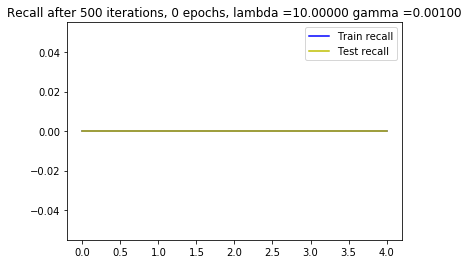

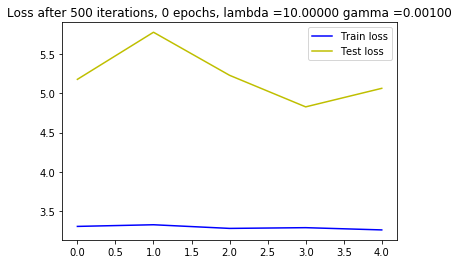

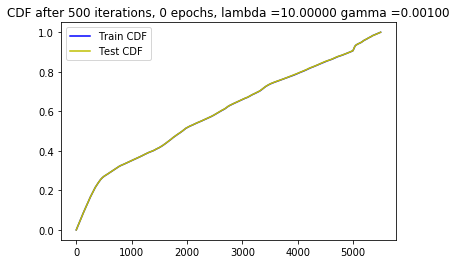



  0%|          | 501/473047 [05:35<2519:49:29, 19.20s/it]

  0%|          | 504/473047 [05:35<1765:26:05, 13.45s/it]

('New score: ', 0.08989737)
('Train score: ', 0.083260536)
('Test score: ', 0.08347969)
('Obj first part: ', 0.0)
('Obj second part: ', -2.389749)
('Obj first part: ', 1.6983765363693237)
('Obj second part: ', -2.4034896)
('Obj first part: ', 1.8233440816402435)
('Obj second part: ', -2.3508904)
('Obj first part: ', 1.695554405450821)
('Obj second part: ', -2.614951)
('Obj first part: ', 1.5038585662841797)
('Obj second part: ', -2.5103948)




  0%|          | 507/473047 [05:35<1237:22:10,  9.43s/it]

  0%|          | 510/473047 [05:36<867:42:04,  6.61s/it] 

('Obj first part: ', 0.0)
('Obj second part: ', -2.564147)
('Obj first part: ', 0.0)
('Obj second part: ', -2.4045825)
('Obj first part: ', 0.0)
('Obj second part: ', -2.2222948)
('Obj first part: ', 2.06283301115036)
('Obj second part: ', -2.2585452)
('Obj first part: ', 0.0)
('Obj second part: ', -2.2976956)
('Obj first part: ', 0.0)
('Obj second part: ', -2.0731957)




  0%|          | 513/473047 [05:36<608:55:44,  4.64s/it]

  0%|          | 516/473047 [05:36<427:47:26,  3.26s/it]

('Obj first part: ', 2.09110751748085)
('Obj second part: ', -2.3371723)
('Obj first part: ', 1.733172982931137)
('Obj second part: ', -2.159357)
('Obj first part: ', 1.8097078800201416)
('Obj second part: ', -2.1137438)
('Obj first part: ', 0.0)
('Obj second part: ', -2.4368567)
('Obj first part: ', 1.93369522690773)
('Obj second part: ', -2.2372437)
('Obj first part: ', 1.8210957944393158)
('Obj second part: ', -2.5840375)




  0%|          | 519/473047 [05:36<301:00:05,  2.29s/it]

  0%|          | 522/473047 [05:36<212:14:04,  1.62s/it]

('Obj first part: ', 0.0)
('Obj second part: ', -2.4985147)
('Obj first part: ', 0.0)
('Obj second part: ', -2.513242)
('Obj first part: ', 0.0)
('Obj second part: ', -2.2027192)
('Obj first part: ', 0.0)
('Obj second part: ', -2.296342)
('Obj first part: ', 0.0)
('Obj second part: ', -2.054693)
('Obj first part: ', 2.552812397480011)
('Obj second part: ', -2.0578578)




  0%|          | 525/473047 [05:36<150:06:48,  1.14s/it]

  0%|          | 528/473047 [05:36<106:37:53,  1.23it/s]

('Obj first part: ', 1.8996462225914001)
('Obj second part: ', -2.248441)
('Obj first part: ', 2.3137158155441284)
('Obj second part: ', -2.2882085)
('Obj first part: ', 0.0)
('Obj second part: ', -2.2464266)
('Obj first part: ', 0.0)
('Obj second part: ', -2.299165)
('Obj first part: ', 2.6176536083221436)
('Obj second part: ', -2.1850991)
('Obj first part: ', 0.0)
('Obj second part: ', -2.2256632)




  0%|          | 531/473047 [05:36<76:12:02,  1.72it/s] 

  0%|          | 534/473047 [05:37<54:54:28,  2.39it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -2.0105066)
('Obj first part: ', 2.4304354190826416)
('Obj second part: ', -2.0858805)
('Obj first part: ', 1.9809137284755707)
('Obj second part: ', -2.1911445)
('Obj first part: ', 1.8093028664588928)
('Obj second part: ', -2.1719356)
('Obj first part: ', 0.0)
('Obj second part: ', -2.1868572)




  0%|          | 537/473047 [05:37<40:00:27,  3.28it/s]

  0%|          | 540/473047 [05:37<29:33:53,  4.44it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -2.5411088)
('Obj first part: ', 0.0)
('Obj second part: ', -2.089459)
('Obj first part: ', 2.5814050436019897)
('Obj second part: ', -2.1957958)
('Obj first part: ', 1.7648924887180328)
('Obj second part: ', -2.3521109)
('Obj first part: ', 2.0754025876522064)
('Obj second part: ', -2.447905)
('Obj first part: ', 2.0945991575717926)
('Obj second part: ', -2.3923876)




  0%|          | 543/473047 [05:37<22:15:00,  5.90it/s]

  0%|          | 546/473047 [05:37<17:08:16,  7.66it/s]

('Obj first part: ', 1.6516800224781036)
('Obj second part: ', -2.5486264)
('Obj first part: ', 0.0)
('Obj second part: ', -2.644144)
('Obj first part: ', 0.0)
('Obj second part: ', -2.572061)
('Obj first part: ', 1.4600400626659393)
('Obj second part: ', -2.5063968)
('Obj first part: ', 0.0)
('Obj second part: ', -2.4716458)
('Obj first part: ', 1.6675187647342682)
('Obj second part: ', -2.3687115)




  0%|          | 549/473047 [05:37<13:33:48,  9.68it/s]

  0%|          | 552/473047 [05:37<11:04:05, 11.86it/s]

('Obj first part: ', 1.4904731512069702)
('Obj second part: ', -2.456218)
('Obj first part: ', 1.6695870459079742)
('Obj second part: ', -2.3919368)
('Obj first part: ', 0.0)
('Obj second part: ', -2.4561872)
('Obj first part: ', 0.0)
('Obj second part: ', -2.2448356)
('Obj first part: ', 2.008143663406372)
('Obj second part: ', -2.4321785)




  0%|          | 555/473047 [05:37<9:19:40, 14.07it/s] 

('Obj first part: ', 0.0)
('Obj second part: ', -2.2982435)
('Obj first part: ', 1.9580654799938202)
('Obj second part: ', -2.3070912)
('Obj first part: ', 1.585683524608612)
('Obj second part: ', -2.1937973)
('Obj first part: ', 1.4587043225765228)
('Obj second part: ', -2.4198856)
('Obj first part: ', 1.4413274824619293)
('Obj second part: ', -2.4576976)
('Obj first part: ', 0.0)
('Obj second part: ', -2.527335)




  0%|          | 558/473047 [05:38<8:04:32, 16.25it/s]

  0%|          | 561/473047 [05:38<7:08:00, 18.40it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -2.4847639)
('Obj first part: ', 0.0)
('Obj second part: ', -2.406105)
('Obj first part: ', 1.9845305383205414)
('Obj second part: ', -2.2888544)
('Obj first part: ', 0.0)
('Obj second part: ', -2.3899643)
('Obj first part: ', 1.6550232470035553)
('Obj second part: ', -2.2984421)
('Obj first part: ', 1.5526071190834045)
('Obj second part: ', -2.331686)




  0%|          | 564/473047 [05:38<6:27:35, 20.32it/s]

  0%|          | 567/473047 [05:38<6:00:22, 21.85it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -2.3480043)
('Obj first part: ', 0.0)
('Obj second part: ', -2.3381097)
('Obj first part: ', 2.1627064049243927)
('Obj second part: ', -2.1460457)
('Obj first part: ', 1.7706714570522308)
('Obj second part: ', -2.3254535)
('Obj first part: ', 1.5530411899089813)
('Obj second part: ', -2.3732123)
('Obj first part: ', 0.0)
('Obj second part: ', -2.4145536)




  0%|          | 570/473047 [05:38<5:41:09, 23.08it/s]

  0%|          | 573/473047 [05:38<5:27:49, 24.02it/s]

('Obj first part: ', 1.651337593793869)
('Obj second part: ', -2.3917193)
('Obj first part: ', 0.0)
('Obj second part: ', -2.4548464)
('Obj first part: ', 0.0)
('Obj second part: ', -2.5643783)
('Obj first part: ', 0.0)
('Obj second part: ', -2.382214)
('Obj first part: ', 0.0)
('Obj second part: ', -2.0186357)
('Obj first part: ', 2.4881385266780853)
('Obj second part: ', -2.2047257)




  0%|          | 576/473047 [05:38<5:19:24, 24.65it/s]

  0%|          | 579/473047 [05:38<5:12:17, 25.22it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -2.2521553)
('Obj first part: ', 0.0)
('Obj second part: ', -2.1730292)
('Obj first part: ', 2.5367364287376404)
('Obj second part: ', -2.0763717)
('Obj first part: ', 0.0)
('Obj second part: ', -2.0805235)
('Obj first part: ', 0.0)
('Obj second part: ', -2.0979865)
('Obj first part: ', 2.3400284349918365)
('Obj second part: ', -1.9505328)




  0%|          | 582/473047 [05:38<5:08:01, 25.56it/s]

  0%|          | 585/473047 [05:39<5:04:17, 25.88it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -2.0530589)
('Obj first part: ', 0.0)
('Obj second part: ', -1.9111712)
('Obj first part: ', 2.4212945997714996)
('Obj second part: ', -2.0437746)
('Obj first part: ', 0.0)
('Obj second part: ', -2.0365803)
('Obj first part: ', 0.0)
('Obj second part: ', -1.9873301)
('Obj first part: ', 2.5132933259010315)
('Obj second part: ', -1.881756)




  0%|          | 588/473047 [05:39<5:01:51, 26.09it/s]

  0%|          | 591/473047 [05:39<5:00:16, 26.22it/s]

('Obj first part: ', 2.6027533411979675)
('Obj second part: ', -1.9825631)
('Obj first part: ', 2.0765143632888794)
('Obj second part: ', -2.1231751)
('Obj first part: ', 1.862701177597046)
('Obj second part: ', -2.1539197)
('Obj first part: ', 0.0)
('Obj second part: ', -2.327872)
('Obj first part: ', 1.9740545749664307)
('Obj second part: ', -2.2350588)
('Obj first part: ', 0.0)
('Obj second part: ', -2.4390688)




  0%|          | 594/473047 [05:39<4:59:28, 26.29it/s]

  0%|          | 597/473047 [05:39<5:00:12, 26.23it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -2.3062525)
('Obj first part: ', 2.284470349550247)
('Obj second part: ', -2.1996572)
('Obj first part: ', 0.0)
('Obj second part: ', -2.309391)
('Obj first part: ', 2.216229736804962)
('Obj second part: ', -2.0607808)
('Obj first part: ', 0.0)
('Obj second part: ', -2.1620014)
('Obj first part: ', 1.906278282403946)
('Obj second part: ', -2.3778284)




  0%|          | 600/473047 [05:39<4:59:59, 26.25it/s]

('Obj first part: ', 1.5755204856395721)
('Obj second part: ', -2.299262)




  0%|          | 600/473047 [05:49<4:59:59, 26.25it/s]

('Train loss first part: ', 0.9112779243737459)
('Train loss second part: ', -2.3373487)
('Test loss first part: ', 0.8903025322407485)




  0%|          | 601/473047 [06:42<2488:57:24, 18.97s/it]

  0%|          | 604/473047 [06:42<1743:44:57, 13.29s/it]

('Test loss second part: ', -2.3395762)
('Obj first part: ', 1.9449523091316223)
('Obj second part: ', -2.4168034)
('Obj first part: ', 0.0)
('Obj second part: ', -2.2983909)
('Obj first part: ', 1.8705946207046509)
('Obj second part: ', -2.1229265)
('Obj first part: ', 0.0)
('Obj second part: ', -2.5094588)
('Obj first part: ', 1.789497286081314)
('Obj second part: ', -2.3355868)
('Obj first part: ', 1.7421315610408783)
('Obj second part: ', -2.2630126)




  0%|          | 607/473047 [06:42<1222:05:44,  9.31s/it]

  0%|          | 610/473047 [06:43<856:56:37,  6.53s/it] 

('Obj first part: ', 1.7607797682285309)
('Obj second part: ', -2.313943)
('Obj first part: ', 0.0)
('Obj second part: ', -2.616749)
('Obj first part: ', 1.5232828259468079)
('Obj second part: ', -2.3861177)
('Obj first part: ', 0.0)
('Obj second part: ', -2.4913561)
('Obj first part: ', 1.9273997843265533)
('Obj second part: ', -2.4922323)
('Obj first part: ', 0.0)
('Obj second part: ', -2.5828917)




  0%|          | 613/473047 [06:43<601:20:57,  4.58s/it]

  0%|          | 616/473047 [06:43<422:25:04,  3.22s/it]

('Obj first part: ', 0.0)
('Obj second part: ', -2.2884605)
('Obj first part: ', 1.8659983575344086)
('Obj second part: ', -2.256325)
('Obj first part: ', 1.5082021057605743)
('Obj second part: ', -2.4621096)
('Obj first part: ', 2.1150656044483185)
('Obj second part: ', -2.574241)
('Obj first part: ', 1.6593992710113525)
('Obj second part: ', -2.5915587)
('Obj first part: ', 1.4163796603679657)
('Obj second part: ', -2.6819582)




  0%|          | 619/473047 [06:43<297:11:57,  2.26s/it]

  0%|          | 622/473047 [06:43<209:30:33,  1.60s/it]

('Obj first part: ', 1.5888598561286926)
('Obj second part: ', -2.458208)
('Obj first part: ', 1.183064952492714)
('Obj second part: ', -2.7638927)
('Obj first part: ', 1.0118773579597473)
('Obj second part: ', -2.6868596)
('Obj first part: ', 0.0)
('Obj second part: ', -2.6736205)
('Obj first part: ', 1.1059430241584778)
('Obj second part: ', -2.9317572)
('Obj first part: ', 1.3697715103626251)
('Obj second part: ', -2.9255104)




  0%|          | 625/473047 [06:43<148:08:35,  1.13s/it]

  0%|          | 628/473047 [06:43<105:11:29,  1.25it/s]

('Obj first part: ', 1.4145410060882568)
('Obj second part: ', -2.7353275)
('Obj first part: ', 1.237201765179634)
('Obj second part: ', -2.624129)
('Obj first part: ', 0.8966793119907379)
('Obj second part: ', -2.7061286)
('Obj first part: ', 0.9672047197818756)
('Obj second part: ', -2.7978282)
('Obj first part: ', 0.988132432103157)
('Obj second part: ', -2.6610968)
('Obj first part: ', 1.154520958662033)
('Obj second part: ', -2.852649)




  0%|          | 631/473047 [06:43<75:08:22,  1.75it/s] 

  0%|          | 634/473047 [06:43<54:06:10,  2.43it/s]

('Obj first part: ', 1.0158967226743698)
('Obj second part: ', -2.7698705)
('Obj first part: ', 1.1055325716733932)
('Obj second part: ', -2.8473256)
('Obj first part: ', 1.031201258301735)
('Obj second part: ', -2.5761535)
('Obj first part: ', 0.9223996102809906)
('Obj second part: ', -2.5524685)
('Obj first part: ', 0.0)
('Obj second part: ', -2.7288206)
('Obj first part: ', 0.0)
('Obj second part: ', -2.9483054)




  0%|          | 637/473047 [06:44<39:24:32,  3.33it/s]

  0%|          | 640/473047 [06:44<29:04:08,  4.51it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -2.4537437)
('Obj first part: ', 0.0)
('Obj second part: ', -2.36608)
('Obj first part: ', 0.0)
('Obj second part: ', -2.371728)
('Obj first part: ', 2.1182407438755035)
('Obj second part: ', -2.2484567)
('Obj first part: ', 0.0)
('Obj second part: ', -2.4362302)
('Obj first part: ', 0.0)
('Obj second part: ', -2.2830524)




  0%|          | 643/473047 [06:44<21:50:36,  6.01it/s]

  0%|          | 646/473047 [06:44<16:45:58,  7.83it/s]

('Obj first part: ', 2.3523204028606415)
('Obj second part: ', -2.0941029)
('Obj first part: ', 1.8995191156864166)
('Obj second part: ', -2.5510645)
('Obj first part: ', 0.0)
('Obj second part: ', -2.4476075)
('Obj first part: ', 0.0)
('Obj second part: ', -2.190715)
('Obj first part: ', 0.0)
('Obj second part: ', -2.3465855)
('Obj first part: ', 2.1059007942676544)
('Obj second part: ', -2.1183515)




  0%|          | 649/473047 [06:44<13:13:59,  9.92it/s]

  0%|          | 652/473047 [06:44<10:44:27, 12.22it/s]

('Obj first part: ', 2.2449317574501038)
('Obj second part: ', -2.2218137)
('Obj first part: ', 1.575043797492981)
('Obj second part: ', -2.317715)
('Obj first part: ', 2.0761698484420776)
('Obj second part: ', -2.3928766)
('Obj first part: ', 0.0)
('Obj second part: ', -2.451077)
('Obj first part: ', 0.0)
('Obj second part: ', -2.366703)
('Obj first part: ', 0.0)
('Obj second part: ', -2.4331682)




  0%|          | 655/473047 [06:44<9:00:46, 14.56it/s] 

  0%|          | 658/473047 [06:44<7:48:38, 16.80it/s]

('Obj first part: ', 2.1290047466754913)
('Obj second part: ', -2.3585908)
('Obj first part: ', 1.8573978543281555)
('Obj second part: ', -2.2504916)
('Obj first part: ', 0.0)
('Obj second part: ', -2.4196067)
('Obj first part: ', 0.0)
('Obj second part: ', -2.4373043)
('Obj first part: ', 2.3482735455036163)
('Obj second part: ', -2.2203674)
('Obj first part: ', 0.0)
('Obj second part: ', -2.2911704)




  0%|          | 661/473047 [06:44<6:58:22, 18.82it/s]

  0%|          | 664/473047 [06:45<6:25:54, 20.40it/s]

('Obj first part: ', 2.0313046872615814)
('Obj second part: ', -2.2013958)
('Obj first part: ', 1.5121300518512726)
('Obj second part: ', -2.3503056)
('Obj first part: ', 0.0)
('Obj second part: ', -2.322843)
('Obj first part: ', 0.0)
('Obj second part: ', -2.370551)
('Obj first part: ', 0.0)
('Obj second part: ', -2.140606)
('Obj first part: ', 0.0)
('Obj second part: ', -2.0279667)




  0%|          | 667/473047 [06:45<5:59:29, 21.90it/s]

  0%|          | 670/473047 [06:45<5:40:29, 23.12it/s]

('Obj first part: ', 1.8588675558567047)
('Obj second part: ', -1.9884115)
('Obj first part: ', 2.088766247034073)
('Obj second part: ', -2.1596394)
('Obj first part: ', 0.0)
('Obj second part: ', -2.271939)
('Obj first part: ', 2.3811663687229156)
('Obj second part: ', -2.2779076)
('Obj first part: ', 1.9299857318401337)
('Obj second part: ', -2.0737958)
('Obj first part: ', 0.0)
('Obj second part: ', -2.3048916)




  0%|          | 673/473047 [06:45<5:26:59, 24.08it/s]

  0%|          | 676/473047 [06:45<5:18:01, 24.76it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -2.1725814)
('Obj first part: ', 0.0)
('Obj second part: ', -2.0237234)
('Obj first part: ', 1.840447187423706)
('Obj second part: ', -2.0375423)
('Obj first part: ', 2.189350575208664)
('Obj second part: ', -2.1485333)
('Obj first part: ', 0.0)
('Obj second part: ', -2.3316662)
('Obj first part: ', 0.0)
('Obj second part: ', -2.1255598)




  0%|          | 679/473047 [06:45<5:13:31, 25.11it/s]

  0%|          | 682/473047 [06:45<5:08:00, 25.56it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -1.9585621)
('Obj first part: ', 2.318396121263504)
('Obj second part: ', -2.08738)
('Obj first part: ', 2.4205489456653595)
('Obj second part: ', -2.1546366)
('Obj first part: ', 1.9223231077194214)
('Obj second part: ', -2.4234629)
('Obj first part: ', 1.6393674910068512)
('Obj second part: ', -2.265543)
('Obj first part: ', 1.422603726387024)
('Obj second part: ', -2.510803)




  0%|          | 685/473047 [06:45<5:04:11, 25.88it/s]

  0%|          | 688/473047 [06:46<5:01:57, 26.07it/s]

('Obj first part: ', 1.5846513211727142)
('Obj second part: ', -2.4249983)
('Obj first part: ', 1.5235304832458496)
('Obj second part: ', -2.3722768)
('Obj first part: ', 1.2362448871135712)
('Obj second part: ', -2.3907123)
('Obj first part: ', 0.0)
('Obj second part: ', -2.908196)
('Obj first part: ', 0.0)
('Obj second part: ', -2.2761595)
('Obj first part: ', 0.0)
('Obj second part: ', -2.401802)




  0%|          | 691/473047 [06:46<5:02:55, 25.99it/s]

  0%|          | 694/473047 [06:46<5:01:19, 26.13it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -2.3140955)
('Obj first part: ', 0.0)
('Obj second part: ', -2.358798)
('Obj first part: ', 2.6097649335861206)
('Obj second part: ', -2.0085917)
('Obj first part: ', 2.377389371395111)
('Obj second part: ', -1.9997131)
('Obj first part: ', 1.727294772863388)
('Obj second part: ', -2.2387373)
('Obj first part: ', 1.365734040737152)
('Obj second part: ', -2.3887863)




  0%|          | 697/473047 [06:46<5:00:09, 26.23it/s]

  0%|          | 700/473047 [06:46<4:59:12, 26.31it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -2.320074)
('Obj first part: ', 0.0)
('Obj second part: ', -2.458455)
('Obj first part: ', 1.7542839050292969)
('Obj second part: ', -2.5672889)
('Obj first part: ', 0.0)
('Obj second part: ', -2.286249)




  0%|          | 700/473047 [06:59<4:59:12, 26.31it/s]

('Train loss first part: ', 0.9972892931997777)
('Train loss second part: ', -2.2344484)
('Test loss first part: ', 0.973216808795929)




  0%|          | 701/473047 [07:50<2505:56:17, 19.10s/it]

  0%|          | 704/473047 [07:50<1755:39:25, 13.38s/it]

('Test loss second part: ', -2.2369602)
('Obj first part: ', 1.9390030205249786)
('Obj second part: ', -2.292623)
('Obj first part: ', 1.7237699031829834)
('Obj second part: ', -2.4779208)
('Obj first part: ', 0.0)
('Obj second part: ', -2.4405563)
('Obj first part: ', 0.0)
('Obj second part: ', -2.372035)
('Obj first part: ', 0.0)
('Obj second part: ', -2.4899957)




  0%|          | 707/473047 [07:50<1230:30:11,  9.38s/it]

  0%|          | 710/473047 [07:50<862:49:02,  6.58s/it] 

('Obj first part: ', 2.37932488322258)
('Obj second part: ', -2.1783214)
('Obj first part: ', 1.5559948980808258)
('Obj second part: ', -2.235873)
('Obj first part: ', 0.0)
('Obj second part: ', -2.3323312)
('Obj first part: ', 0.0)
('Obj second part: ', -2.135002)
('Obj first part: ', 1.8991243839263916)
('Obj second part: ', -2.0769374)
('Obj first part: ', 0.0)
('Obj second part: ', -2.3567724)




  0%|          | 713/473047 [07:50<605:27:15,  4.61s/it]

  0%|          | 716/473047 [07:50<425:17:17,  3.24s/it]

('Obj first part: ', 0.0)
('Obj second part: ', -2.1844935)
('Obj first part: ', 2.4389736354351044)
('Obj second part: ', -2.0185773)
('Obj first part: ', 0.0)
('Obj second part: ', -2.2993445)
('Obj first part: ', 2.7370235323905945)
('Obj second part: ', -2.1982305)
('Obj first part: ', 2.0272690057754517)
('Obj second part: ', -2.3528388)
('Obj first part: ', 0.0)
('Obj second part: ', -2.2269127)




  0%|          | 719/473047 [07:50<299:13:34,  2.28s/it]

  0%|          | 722/473047 [07:50<210:57:48,  1.61s/it]

('Obj first part: ', 0.0)
('Obj second part: ', -2.2445507)
('Obj first part: ', 0.0)
('Obj second part: ', -2.1682415)
('Obj first part: ', 2.343478351831436)
('Obj second part: ', -2.0268924)
('Obj first part: ', 0.0)
('Obj second part: ', -2.045353)
('Obj first part: ', 2.0977601408958435)
('Obj second part: ', -2.080949)
('Obj first part: ', 1.9099655747413635)
('Obj second part: ', -2.1948307)




  0%|          | 725/473047 [07:50<149:09:28,  1.14s/it]

  0%|          | 728/473047 [07:51<105:53:25,  1.24it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -2.065818)
('Obj first part: ', 0.0)
('Obj second part: ', -2.1373727)
('Obj first part: ', 0.0)
('Obj second part: ', -2.161075)
('Obj first part: ', 2.507050633430481)
('Obj second part: ', -1.9256568)
('Obj first part: ', 1.903235763311386)
('Obj second part: ', -2.0278902)
('Obj first part: ', 2.1284161508083344)
('Obj second part: ', -2.3168764)




  0%|          | 731/473047 [07:51<75:38:45,  1.73it/s] 

  0%|          | 734/473047 [07:51<54:25:40,  2.41it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -2.0774076)
('Obj first part: ', 1.9264377653598785)
('Obj second part: ', -2.2179322)
('Obj first part: ', 0.0)
('Obj second part: ', -2.4163036)
('Obj first part: ', 0.0)
('Obj second part: ', -2.2901227)
('Obj first part: ', 0.0)
('Obj second part: ', -2.1160386)
('Obj first part: ', 2.4847054481506348)
('Obj second part: ', -1.8291197)




  0%|          | 737/473047 [07:51<39:36:36,  3.31it/s]

  0%|          | 740/473047 [07:51<29:15:56,  4.48it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -2.1873198)
('Obj first part: ', 2.31318399310112)
('Obj second part: ', -2.1013942)
('Obj first part: ', 2.0920217037200928)
('Obj second part: ', -2.2075303)
('Obj first part: ', 0.0)
('Obj second part: ', -2.4728432)
('Obj first part: ', 1.7324259877204895)
('Obj second part: ', -2.1462245)
('Obj first part: ', 1.6890859603881836)
('Obj second part: ', -2.237246)




  0%|          | 743/473047 [07:51<21:57:53,  5.97it/s]

  0%|          | 746/473047 [07:51<16:51:08,  7.78it/s]

('Obj first part: ', 1.9108714163303375)
('Obj second part: ', -2.3365993)
('Obj first part: ', 1.3723903894424438)
('Obj second part: ', -2.4463785)
('Obj first part: ', 0.0)
('Obj second part: ', -2.5218005)
('Obj first part: ', 1.9011755287647247)
('Obj second part: ', -2.4976876)
('Obj first part: ', 1.2713804841041565)
('Obj second part: ', -2.4334288)
('Obj first part: ', 0.0)
('Obj second part: ', -2.7051818)




  0%|          | 749/473047 [07:51<13:16:21,  9.88it/s]

  0%|          | 752/473047 [07:51<10:47:11, 12.16it/s]

('Obj first part: ', 1.450355052947998)
('Obj second part: ', -2.4540923)
('Obj first part: ', 1.5863832831382751)
('Obj second part: ', -2.4152865)
('Obj first part: ', 0.0)
('Obj second part: ', -2.5467992)
('Obj first part: ', 1.6470438241958618)
('Obj second part: ', -2.1114087)
('Obj first part: ', 0.0)
('Obj second part: ', -2.6043737)
('Obj first part: ', 1.7859601974487305)
('Obj second part: ', -2.1995912)




  0%|          | 755/473047 [07:52<9:03:24, 14.49it/s] 

  0%|          | 758/473047 [07:52<7:52:50, 16.65it/s]

('Obj first part: ', 1.4706504344940186)
('Obj second part: ', -2.1970267)
('Obj first part: ', 0.0)
('Obj second part: ', -2.6112504)
('Obj first part: ', 0.0)
('Obj second part: ', -2.2773743)
('Obj first part: ', 1.735956221818924)
('Obj second part: ', -2.3437397)
('Obj first part: ', 1.3388240337371826)
('Obj second part: ', -2.2419667)
('Obj first part: ', 0.0)
('Obj second part: ', -2.487948)




  0%|          | 761/473047 [07:52<7:06:02, 18.48it/s]

  0%|          | 764/473047 [07:52<6:31:22, 20.11it/s]

('Obj first part: ', 1.5199558436870575)
('Obj second part: ', -2.4423134)
('Obj first part: ', 0.0)
('Obj second part: ', -2.2646909)
('Obj first part: ', 0.0)
('Obj second part: ', -2.3896112)
('Obj first part: ', 0.0)
('Obj second part: ', -2.0860276)
('Obj first part: ', 2.158392071723938)
('Obj second part: ', -2.2839456)
('Obj first part: ', 0.0)
('Obj second part: ', -2.2941759)




  0%|          | 767/473047 [07:52<6:05:58, 21.51it/s]

  0%|          | 770/473047 [07:52<5:47:55, 22.62it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -2.1131396)
('Obj first part: ', 2.4405433237552643)
('Obj second part: ', -1.9341699)
('Obj first part: ', 0.0)
('Obj second part: ', -2.1618018)
('Obj first part: ', 0.0)
('Obj second part: ', -2.2202032)
('Obj first part: ', 0.0)
('Obj second part: ', -2.1859808)
('Obj first part: ', 0.0)
('Obj second part: ', -2.0792694)




  0%|          | 773/473047 [07:52<5:34:03, 23.56it/s]

  0%|          | 776/473047 [07:52<5:25:42, 24.17it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -1.7997706)
('Obj first part: ', 0.0)
('Obj second part: ', -2.042916)
('Obj first part: ', 0.0)
('Obj second part: ', -1.6620629)
('Obj first part: ', 0.0)
('Obj second part: ', -1.7322047)
('Obj first part: ', 3.256348669528961)
('Obj second part: ', -1.6457162)
('Obj first part: ', 0.0)
('Obj second part: ', -1.8739)




  0%|          | 779/473047 [07:53<5:19:41, 24.62it/s]

  0%|          | 782/473047 [07:53<5:17:06, 24.82it/s]

('Obj first part: ', 3.3489766716957092)
('Obj second part: ', -1.5887818)
('Obj first part: ', 2.5638052821159363)
('Obj second part: ', -1.8549211)
('Obj first part: ', 2.5259074568748474)
('Obj second part: ', -2.2658691)
('Obj first part: ', 0.0)
('Obj second part: ', -2.0699322)
('Obj first part: ', 2.6470917463302612)
('Obj second part: ', -1.6692958)
('Obj first part: ', 2.446771413087845)
('Obj second part: ', -2.1635823)




  0%|          | 785/473047 [07:53<5:14:00, 25.07it/s]

  0%|          | 788/473047 [07:53<5:12:03, 25.22it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -2.379925)
('Obj first part: ', 1.9446443021297455)
('Obj second part: ', -2.1376297)
('Obj first part: ', 0.0)
('Obj second part: ', -2.3058302)
('Obj first part: ', 2.0800739526748657)
('Obj second part: ', -2.1910036)
('Obj first part: ', 1.8947209417819977)
('Obj second part: ', -2.5846581)
('Obj first part: ', 1.3050511479377747)
('Obj second part: ', -2.2973704)




  0%|          | 791/473047 [07:53<5:10:14, 25.37it/s]

  0%|          | 794/473047 [07:53<5:10:21, 25.36it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -2.4162276)
('Obj first part: ', 0.0)
('Obj second part: ', -2.1644568)
('Obj first part: ', 0.0)
('Obj second part: ', -2.4411745)
('Obj first part: ', 1.8774068355560303)
('Obj second part: ', -2.194524)
('Obj first part: ', 0.0)
('Obj second part: ', -2.2671282)
('Obj first part: ', 0.0)
('Obj second part: ', -2.2760444)




  0%|          | 797/473047 [07:53<5:08:08, 25.54it/s]

  0%|          | 800/473047 [07:53<5:06:59, 25.64it/s]

('Obj first part: ', 2.1069033443927765)
('Obj second part: ', -2.0672069)
('Obj first part: ', 2.209153175354004)
('Obj second part: ', -2.2403722)
('Obj first part: ', 1.6594454646110535)
('Obj second part: ', -2.056662)
('Obj first part: ', 2.2054995596408844)
('Obj second part: ', -2.2386434)
('Obj first part: ', 0.0)
('Obj second part: ', -2.5479965)




  0%|          | 800/473047 [08:09<5:06:59, 25.64it/s]

('Train loss first part: ', 0.8851205155551434)
('Train loss second part: ', -2.3301756)
('Test loss first part: ', 0.8630302154570818)




  0%|          | 801/473047 [08:57<2505:57:43, 19.10s/it]

  0%|          | 804/473047 [08:57<1755:39:14, 13.38s/it]

('Test loss second part: ', -2.3335512)
('Obj first part: ', 0.0)
('Obj second part: ', -2.3019125)
('Obj first part: ', 1.8621134757995605)
('Obj second part: ', -2.0808804)
('Obj first part: ', 0.0)
('Obj second part: ', -2.3686583)
('Obj first part: ', 0.0)
('Obj second part: ', -2.192589)
('Obj first part: ', 2.4166977405548096)
('Obj second part: ', -2.086665)
('Obj first part: ', 0.0)
('Obj second part: ', -2.3306746)




  0%|          | 807/473047 [08:57<1230:25:45,  9.38s/it]

  0%|          | 810/473047 [08:57<862:47:12,  6.58s/it] 

('Obj first part: ', 0.0)
('Obj second part: ', -2.213593)
('Obj first part: ', 0.0)
('Obj second part: ', -2.0909069)
('Obj first part: ', 0.0)
('Obj second part: ', -2.1286438)
('Obj first part: ', 0.0)
('Obj second part: ', -1.8755128)
('Obj first part: ', 3.471921980381012)
('Obj second part: ', -1.9422582)
('Obj first part: ', 1.9364212453365326)
('Obj second part: ', -2.0534217)




  0%|          | 813/473047 [08:57<605:25:59,  4.62s/it]

  0%|          | 816/473047 [08:58<425:16:53,  3.24s/it]

('Obj first part: ', 2.0473334193229675)
('Obj second part: ', -1.8632911)
('Obj first part: ', 0.0)
('Obj second part: ', -2.0100396)
('Obj first part: ', 0.0)
('Obj second part: ', -2.2477553)
('Obj first part: ', 0.0)
('Obj second part: ', -2.217733)
('Obj first part: ', 1.831468641757965)
('Obj second part: ', -1.8598368)
('Obj first part: ', 0.0)
('Obj second part: ', -1.969934)




  0%|          | 819/473047 [08:58<299:10:46,  2.28s/it]

  0%|          | 822/473047 [08:58<210:55:56,  1.61s/it]

('Obj first part: ', 0.0)
('Obj second part: ', -2.0140285)
('Obj first part: ', 0.0)
('Obj second part: ', -1.7552668)
('Obj first part: ', 0.0)
('Obj second part: ', -2.1285846)
('Obj first part: ', 0.0)
('Obj second part: ', -1.904897)
('Obj first part: ', 0.0)
('Obj second part: ', -1.7408123)
('Obj first part: ', 0.0)
('Obj second part: ', -1.6704363)




  0%|          | 825/473047 [08:58<149:07:10,  1.14s/it]

  0%|          | 828/473047 [08:58<105:49:29,  1.24it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -1.6136551)
('Obj first part: ', 0.0)
('Obj second part: ', -1.4637599)
('Obj first part: ', 0.0)
('Obj second part: ', -1.3667321)
('Obj first part: ', 0.0)
('Obj second part: ', -1.4474603)
('Obj first part: ', 0.0)
('Obj second part: ', -1.418864)
('Obj first part: ', 0.0)
('Obj second part: ', -1.5483333)




  0%|          | 831/473047 [08:58<75:33:29,  1.74it/s] 

  0%|          | 834/473047 [08:58<54:22:35,  2.41it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -1.4841111)
('Obj first part: ', 0.0)
('Obj second part: ', -1.304313)
('Obj first part: ', 0.0)
('Obj second part: ', -1.417512)
('Obj first part: ', 5.9158337116241455)
('Obj second part: ', -1.3190486)
('Obj first part: ', 0.0)
('Obj second part: ', -1.5159502)
('Obj first part: ', 4.6897077560424805)
('Obj second part: ', -1.4657061)




  0%|          | 837/473047 [08:58<39:34:40,  3.31it/s]

  0%|          | 840/473047 [08:58<29:10:37,  4.50it/s]

('Obj first part: ', 4.0319085121154785)
('Obj second part: ', -1.488733)
('Obj first part: ', 4.334527850151062)
('Obj second part: ', -1.6111288)
('Obj first part: ', 3.6986523866653442)
('Obj second part: ', -1.9120659)
('Obj first part: ', 0.0)
('Obj second part: ', -1.7725582)
('Obj first part: ', 0.0)
('Obj second part: ', -2.080159)
('Obj first part: ', 4.263629913330078)
('Obj second part: ', -1.8815578)




  0%|          | 843/473047 [08:59<21:54:42,  5.99it/s]

  0%|          | 846/473047 [08:59<16:51:58,  7.78it/s]

('Obj first part: ', 2.544391453266144)
('Obj second part: ', -1.7919774)
('Obj first part: ', 0.0)
('Obj second part: ', -1.8539381)
('Obj first part: ', 0.0)
('Obj second part: ', -2.2924798)
('Obj first part: ', 0.0)
('Obj second part: ', -1.912202)
('Obj first part: ', 3.09397429227829)
('Obj second part: ', -1.6863801)
('Obj first part: ', 3.015602231025696)
('Obj second part: ', -2.0266938)




  0%|          | 849/473047 [08:59<13:19:23,  9.84it/s]

  0%|          | 852/473047 [08:59<10:48:53, 12.13it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -1.9388047)
('Obj first part: ', 3.2600685954093933)
('Obj second part: ', -2.2706275)
('Obj first part: ', 0.0)
('Obj second part: ', -2.1072307)
('Obj first part: ', 2.359032481908798)
('Obj second part: ', -2.3883536)
('Obj first part: ', 0.0)
('Obj second part: ', -2.4936519)
('Obj first part: ', 2.014884501695633)
('Obj second part: ', -2.2949932)




  0%|          | 855/473047 [08:59<9:03:04, 14.49it/s] 

  0%|          | 858/473047 [08:59<7:48:36, 16.79it/s]

('Obj first part: ', 2.0424719154834747)
('Obj second part: ', -2.2903354)
('Obj first part: ', 0.0)
('Obj second part: ', -2.2300873)
('Obj first part: ', 0.0)
('Obj second part: ', -2.2987943)
('Obj first part: ', 1.9851289689540863)
('Obj second part: ', -2.3481462)
('Obj first part: ', 0.0)
('Obj second part: ', -2.0757394)
('Obj first part: ', 0.0)
('Obj second part: ', -2.0447779)




  0%|          | 861/473047 [08:59<6:58:15, 18.82it/s]

  0%|          | 864/473047 [08:59<6:22:51, 20.56it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -2.484704)
('Obj first part: ', 0.0)
('Obj second part: ', -1.7401749)
('Obj first part: ', 0.0)
('Obj second part: ', -2.2512884)
('Obj first part: ', 3.13161164522171)
('Obj second part: ', -1.5808339)
('Obj first part: ', 3.035302758216858)
('Obj second part: ', -2.132647)
('Obj first part: ', 1.4546827971935272)
('Obj second part: ', -2.2657454)




  0%|          | 867/473047 [08:59<5:58:54, 21.93it/s]

  0%|          | 870/473047 [09:00<5:43:52, 22.89it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -2.2843947)
('Obj first part: ', 0.0)
('Obj second part: ', -2.2503562)
('Obj first part: ', 3.033786714076996)
('Obj second part: ', -1.8378596)
('Obj first part: ', 0.0)
('Obj second part: ', -2.0137742)
('Obj first part: ', 0.0)
('Obj second part: ', -2.1901531)
('Obj first part: ', 2.2154806554317474)
('Obj second part: ', -1.8814691)




  0%|          | 873/473047 [09:00<5:33:30, 23.60it/s]

  0%|          | 876/473047 [09:00<5:25:52, 24.15it/s]

('Obj first part: ', 2.118523418903351)
('Obj second part: ', -2.0374334)
('Obj first part: ', 2.1676522493362427)
('Obj second part: ', -1.8475313)
('Obj first part: ', 0.0)
('Obj second part: ', -2.3288083)
('Obj first part: ', 0.0)
('Obj second part: ', -2.2614553)
('Obj first part: ', 2.041901797056198)
('Obj second part: ', -2.0864599)
('Obj first part: ', 0.0)
('Obj second part: ', -2.390731)




  0%|          | 879/473047 [09:00<5:20:54, 24.52it/s]

  0%|          | 882/473047 [09:00<5:16:46, 24.84it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -2.052026)
('Obj first part: ', 2.357752025127411)
('Obj second part: ', -2.258829)
('Obj first part: ', 0.0)
('Obj second part: ', -2.1077225)
('Obj first part: ', 0.0)
('Obj second part: ', -2.3439898)
('Obj first part: ', 0.0)
('Obj second part: ', -2.302364)
('Obj first part: ', 1.9360816478729248)
('Obj second part: ', -1.8987195)




  0%|          | 885/473047 [09:00<5:14:13, 25.04it/s]

  0%|          | 888/473047 [09:00<5:13:03, 25.14it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -2.1405926)
('Obj first part: ', 2.3839253187179565)
('Obj second part: ', -1.985881)
('Obj first part: ', 0.0)
('Obj second part: ', -2.0332172)
('Obj first part: ', 0.0)
('Obj second part: ', -2.0751326)
('Obj first part: ', 0.0)
('Obj second part: ', -2.1545675)
('Obj first part: ', 2.358849346637726)
('Obj second part: ', -1.9119966)




  0%|          | 891/473047 [09:00<5:10:36, 25.33it/s]

  0%|          | 894/473047 [09:01<5:09:54, 25.39it/s]

('Obj first part: ', 2.632940411567688)
('Obj second part: ', -2.0314236)
('Obj first part: ', 2.352183163166046)
('Obj second part: ', -2.0595796)
('Obj first part: ', 0.0)
('Obj second part: ', -2.0518482)
('Obj first part: ', 1.9753062725067139)
('Obj second part: ', -1.9734015)
('Obj first part: ', 2.5723016262054443)
('Obj second part: ', -2.279134)
('Obj first part: ', 0.0)
('Obj second part: ', -2.1218362)




  0%|          | 897/473047 [09:01<5:08:32, 25.50it/s]

  0%|          | 900/473047 [09:01<5:06:30, 25.67it/s]

('Obj first part: ', 0.0)
('Obj second part: ', -2.38206)
('Obj first part: ', 1.9269612431526184)
('Obj second part: ', -2.225573)
('Obj first part: ', 0.0)
('Obj second part: ', -2.4882503)
('Obj first part: ', 2.216065376996994)
('Obj second part: ', -2.2273123)


In [ ]:
for g in gammas:
    for l in lambdas:
        print("Lambda: " + str(l) + " Gamma: " + str(g))
        model = MoreComplexNet()
        model.apply(weights_init)
        model.cuda()
        sgd(gamma=g, lamb=l, save_checkpoints=True)

In [ ]:
# For loading the checkpointed model
# for g in range(len(gammas)):
#     for l in range(len(lambdas)):
#         model = SimpleConvNet()
#         optim = SGD(model.parameters(), lr=gamma)
#         checkpoint = torch.load('../models/model.pth')
#         model.load_state_dict(checkpoint['model_state_dict'])
#         optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#         epoch = checkpoint['epoch']
#         model.to(device)
#         sgd(gamma=gammas[g], lamb=lambdas[l])        